# Intron retention
Test the effect of retained introns on RNA-GPS predictions. For this, we have the same set of transcripts, one version with retained introns and one without. Retained introns are combined with the coding sequence for featurization purposes.

In [225]:
import os, sys
import importlib
import pickle

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy.stats

import pyfaidx

SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "rnagps")
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)

SEED = 27492
np.random.seed(SEED)

plt.style.use(['default', os.path.join(SRC_DIR, 'seaborn-paper-custom.mplstyle')])

In [2]:
with open("nes_nls_rf_model.sklearn", 'rb') as source:
    rf_nes_nls_model = pickle.load(source)

In [3]:
importlib.reload(data_loader)
ri_full_dataset = data_loader.NLSvNESRetainedIntronDataset(split='all')
ri_full_data = data_loader.load_data_as_np(ri_full_dataset)

In [4]:
ri_full_data[0].shape, ri_full_data[1].shape

((2868, 4032), (2868,))

In [5]:
# Perfect 50/50 classes due to how we construct dataset
np.sum(ri_full_data[1]) / ri_full_data[1].size

0.5

In [6]:
no_intron_idx = np.where(ri_full_data[1] == 0)[0]
print(no_intron_idx)
with_intron_idx = np.where(ri_full_data[1] == 1)[0]
print(with_intron_idx)
assert not set(no_intron_idx).intersection(set(with_intron_idx))

[   0    2    4 ... 2862 2864 2866]
[   1    3    5 ... 2863 2865 2867]


In [201]:
# For model, 1 means nuclear and 0 is cytosolic
# We should see a positive correlation
ri_preds = rf_nes_nls_model.predict_proba(ri_full_data[0])[:, 1].flatten()
ri_preds

array([0.72354639, 0.76844531, 0.48523247, ..., 0.56009265, 0.10054705,
       0.47050318])

In [198]:
all_transcripts = [ri_full_dataset.get_most_common_transcript(g) for g in ri_full_dataset.gene_ids]
all_transcripts[:5]

['ENST00000373944.7',
 'ENST00000370141.6',
 'ENST00000368009.6',
 'ENST00000584577.5',
 'ENST00000561725.5']

In [8]:
ri_preds_no_intron = ri_preds[no_intron_idx]
ri_preds_with_intron = ri_preds[with_intron_idx]
assert ri_preds_no_intron.size == ri_preds_with_intron.size == len(ri_full_dataset.gene_ids)

In [192]:
ri_preds_no_intron

array([0.72354639, 0.48523247, 0.63545487, ..., 0.81372288, 0.52967141,
       0.10054705])

In [202]:
ri_preds_no_intron_named = pd.Series(ri_preds_no_intron, index=all_transcripts)
ri_preds_with_intron_named = pd.Series(ri_preds_with_intron, index=all_transcripts)

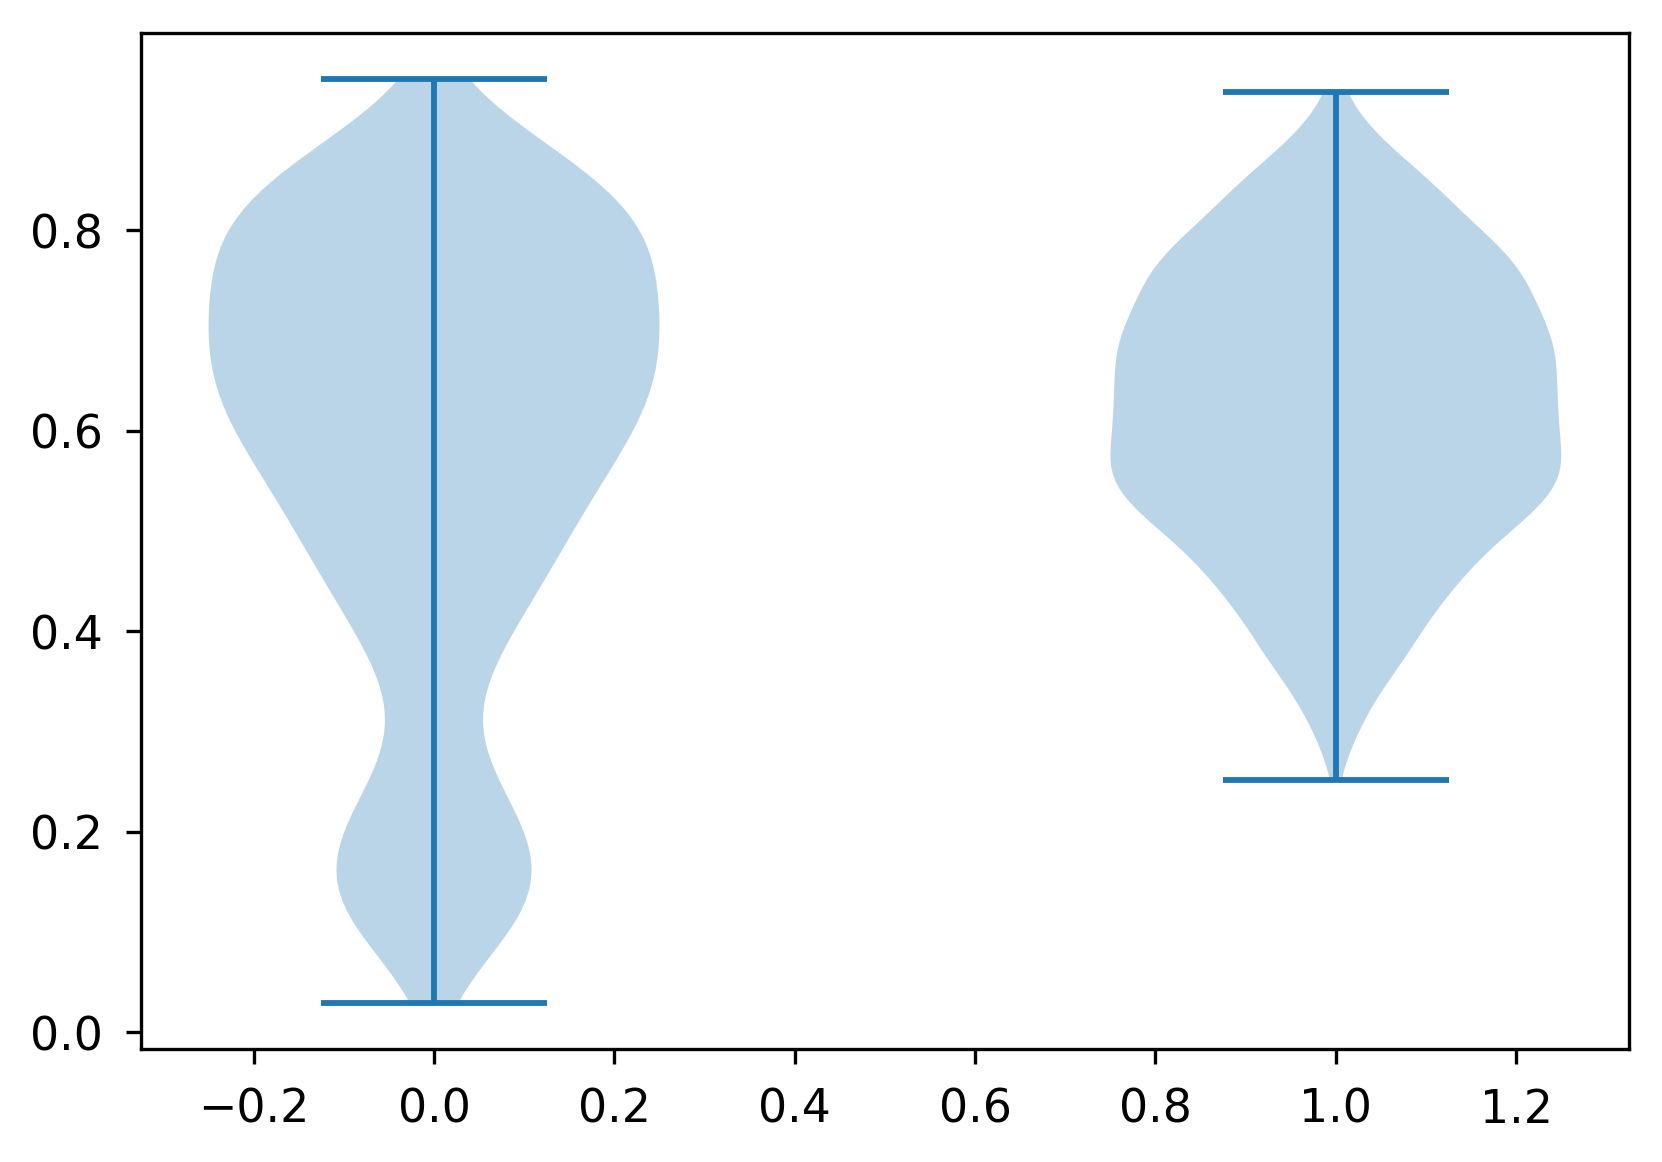

In [32]:
fig, ax = plt.subplots(dpi=300)
ax.violinplot(
    [ri_preds_no_intron, ri_preds_with_intron],
    [0, 1],
)
fig.show()

In [33]:
scipy.stats.ttest_rel(ri_preds_with_intron, ri_preds_no_intron)

Ttest_relResult(statistic=13.33066626363871, pvalue=2.649083530037789e-38)

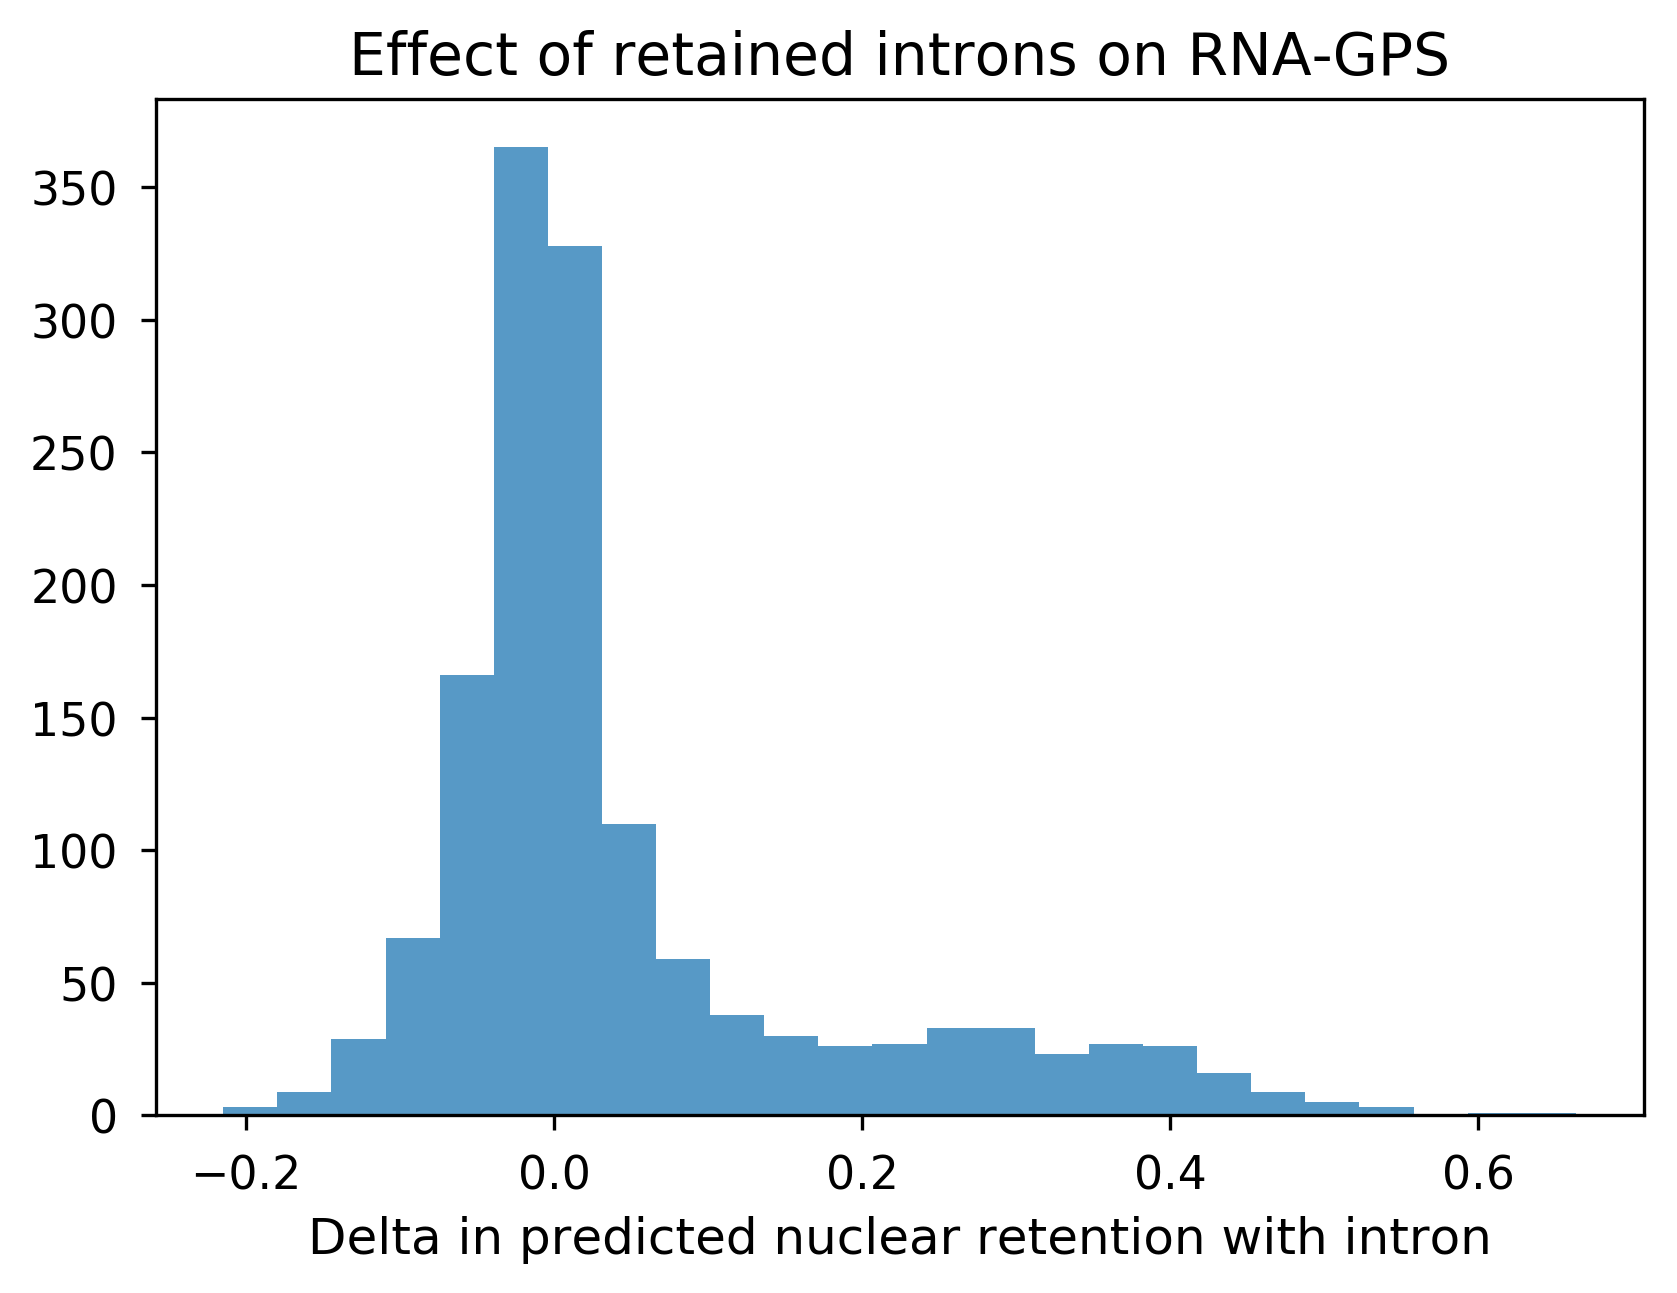

In [34]:
ri_preds_delta = ri_preds_with_intron - ri_preds_no_intron
fig, ax = plt.subplots(dpi=300)
ax.hist(ri_preds_delta, bins=25, alpha=0.75, label='Delta')
ax.set(
    title="Effect of retained introns on RNA-GPS",
    xlabel="Delta in predicted nuclear retention with intron",
)
fig.show()

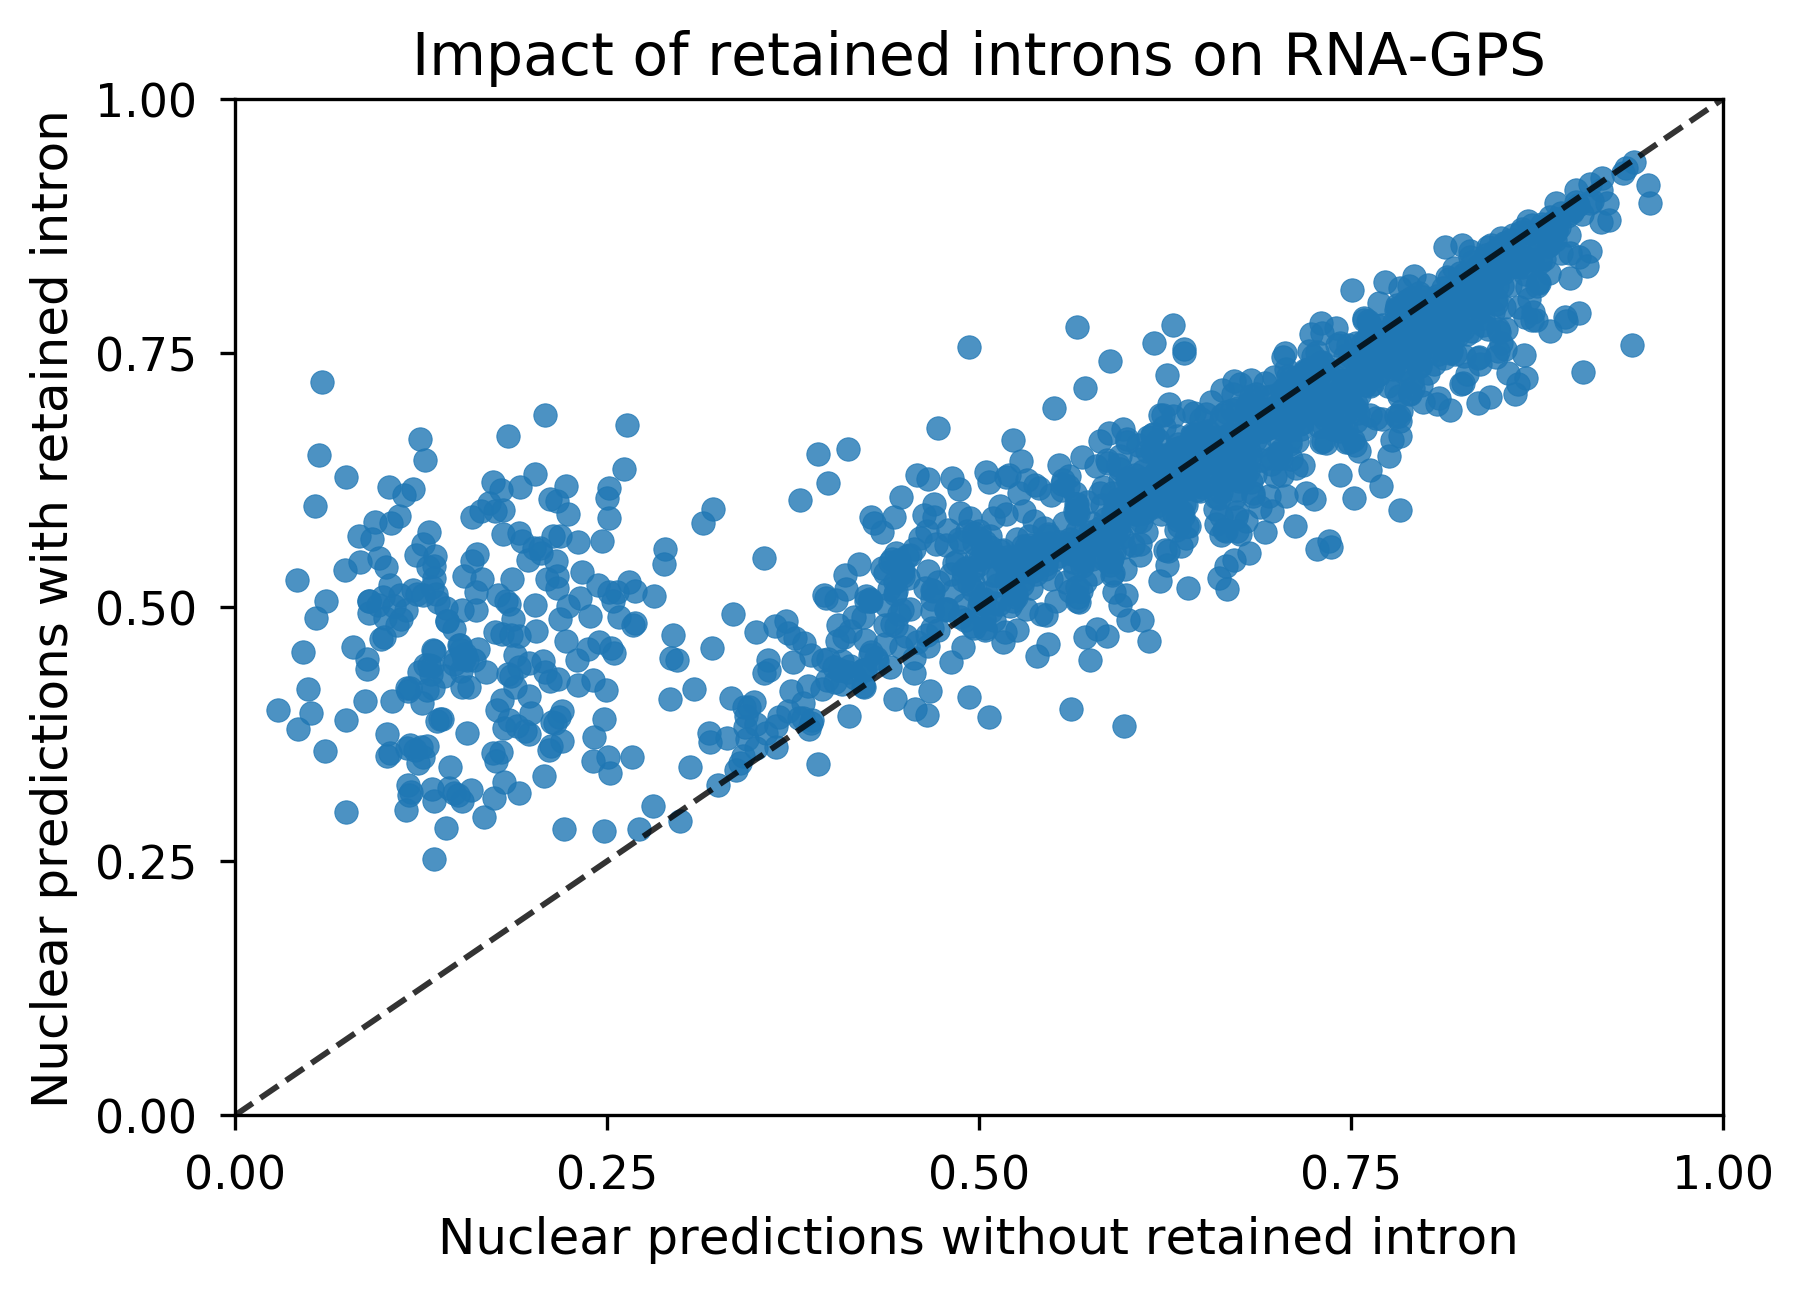

In [60]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(ri_preds_no_intron, ri_preds_with_intron, alpha=0.8)
ax.plot((0, 1), (0, 1), color='black', linestyle='--', alpha=0.8)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    xticks=np.arange(0, 1.1, 0.25),
    yticks=np.arange(0, 1.1, 0.25),
    xlabel="Nuclear predictions without retained intron",
    ylabel="Nuclear predictions with retained intron",
    title="Impact of retained introns on RNA-GPS",
)
# ax.set_aspect('equal', 'box')
fig.savefig(os.path.join(PLOT_DIR, "retained_intron_scatter.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

In [13]:
print(np.sum(ri_preds_no_intron >= 0.5) / ri_preds_no_intron.size)

0.6931659693165969


In [14]:
print(np.sum(ri_preds_with_intron >= 0.5) / ri_preds_with_intron.size)

0.8040446304044631


## Pull out the genes that are getting boosted

In [40]:
boosted_idx = np.where(np.logical_and(
    np.logical_and(ri_preds_no_intron <= 0.3, ri_preds_with_intron > 0.5),
    per_gene_tpm > 750,
))[0]
boosted_gene_ids = [ri_full_dataset.gene_ids[i] for i in boosted_idx]
len(boosted_gene_ids)

19

In [54]:
# Possible candidates
# DDX39B
# SNHG1
# NAA10
all_genes = [set(ri_full_dataset.ri_table[ri_full_dataset.ri_table['GeneID'] == gene_id]['geneSymbol']).pop() for gene_id in ri_full_dataset.gene_ids]
boosted_genes = [set(ri_full_dataset.ri_table[ri_full_dataset.ri_table['GeneID'] == gene_id]['geneSymbol']).pop() for gene_id in boosted_gene_ids]
# print("\n".join(boosted_genes))

In [58]:
example_idx = all_genes.index("DDX39B")
ri_full_dataset.gene_ids[example_idx]

'ENSG00000198563.13'

Go back and highlight chosen gene in scatterplot

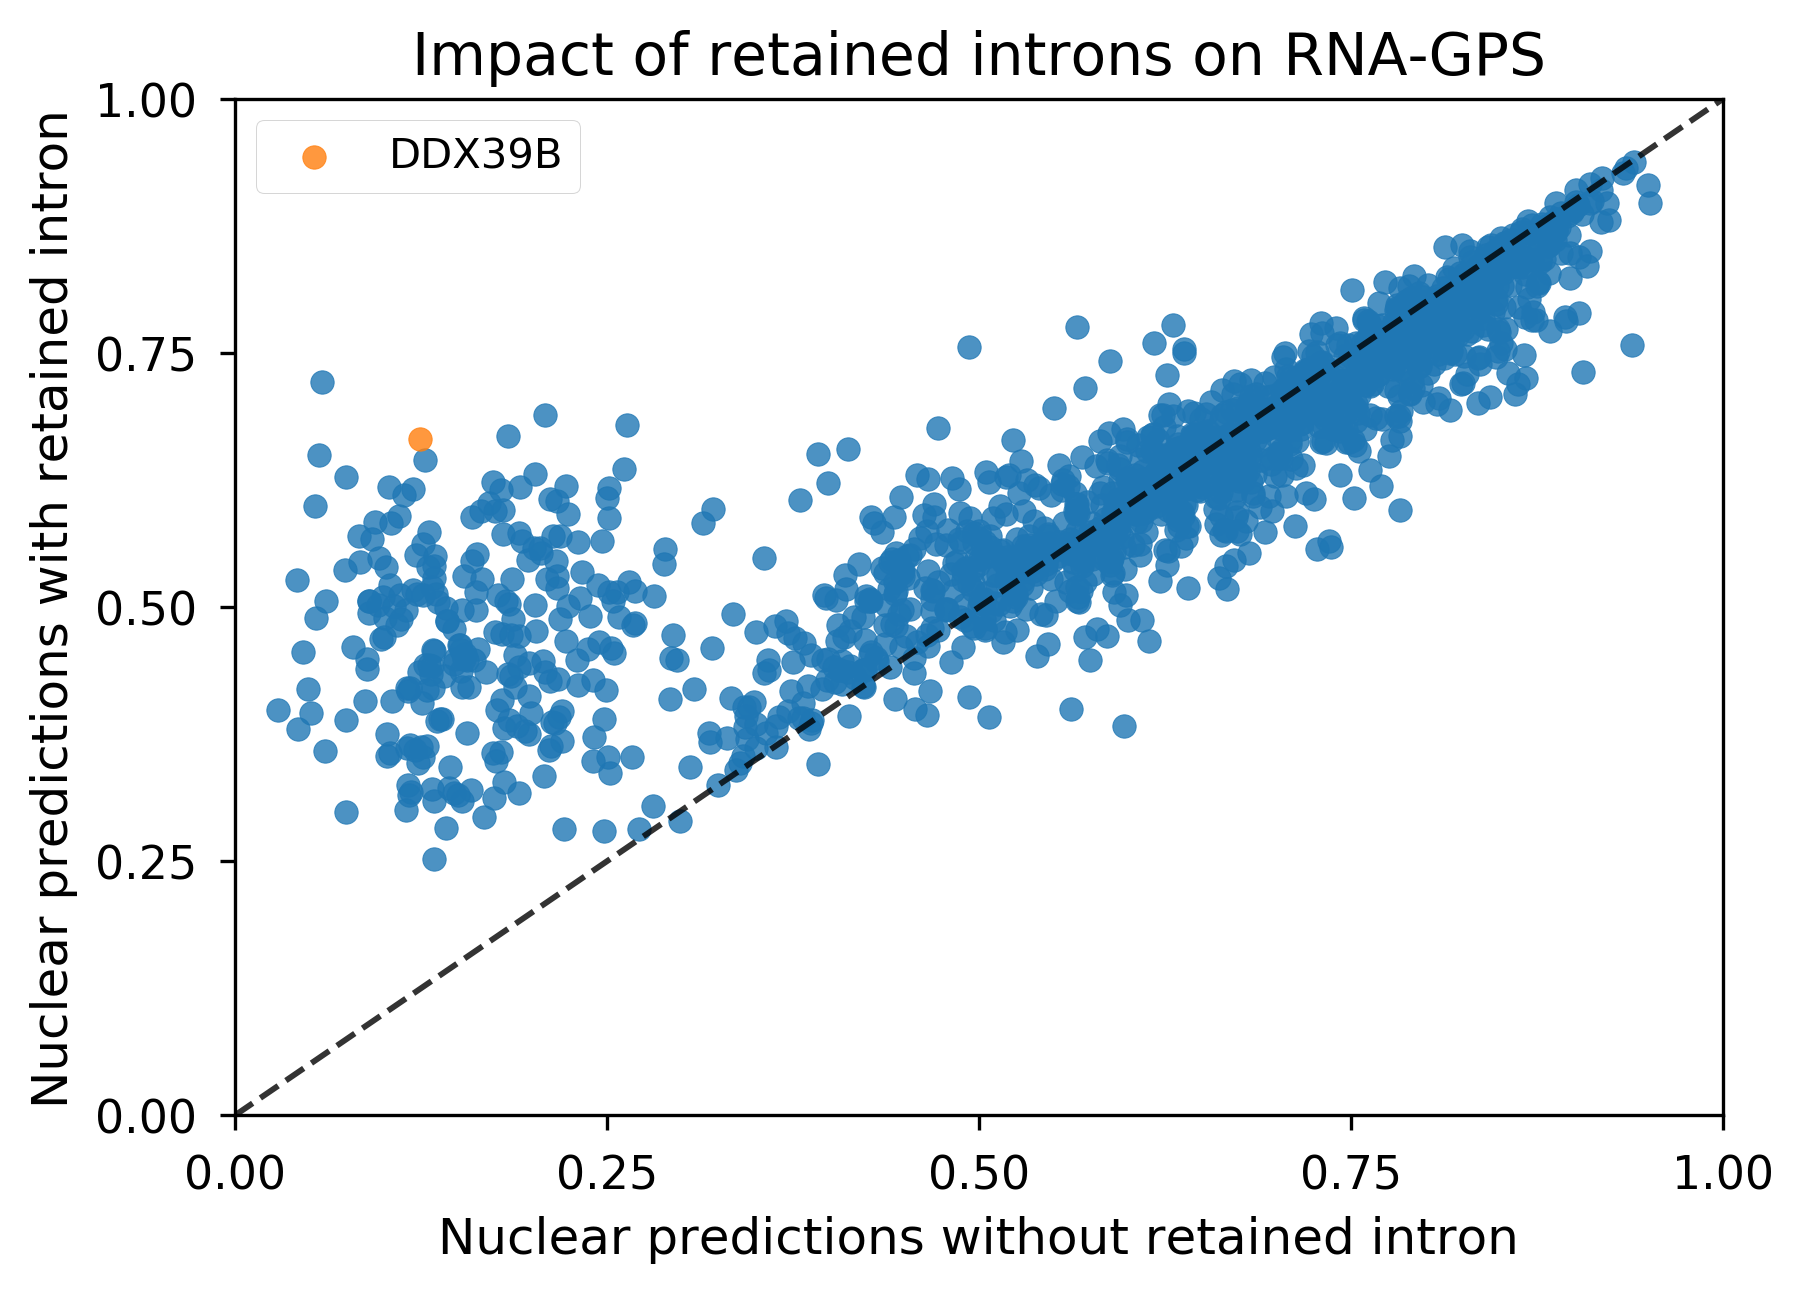

In [63]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(np.delete(ri_preds_no_intron, example_idx), np.delete(ri_preds_with_intron, example_idx), alpha=0.8)
ax.scatter(ri_preds_no_intron[example_idx], ri_preds_with_intron[example_idx], alpha=0.8, label="DDX39B")
ax.plot((0, 1), (0, 1), color='black', linestyle='--', alpha=0.8)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    xticks=np.arange(0, 1.1, 0.25),
    yticks=np.arange(0, 1.1, 0.25),
    xlabel="Nuclear predictions without retained intron",
    ylabel="Nuclear predictions with retained intron",
    title="Impact of retained introns on RNA-GPS",
)
ax.legend()
# ax.set_aspect('equal', 'box')
fig.savefig(os.path.join(PLOT_DIR, "retained_intron_scatter_highlight.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

## Annotate with labels from localization

In [42]:
nes_nls_loc_table = pd.read_csv(
    os.path.join(data_loader.LOCAL_DATA_DIR, "deseq_nls_nes.txt"),
    delimiter="\t",
    engine='c',
    index_col=0,
)

In [224]:
# Labels are -1 for cyto, 0 for ambiguous, 1 for nuclear
ri_labels = []
ri_labels_logfc = []
for g in ri_full_dataset.gene_ids:
    g_row = nes_nls_loc_table.loc[g]
    if g_row['pvalue'] > 0.05:
        ri_labels.append(0)
    else:  # Is significant
        if g_row['log2FoldChange'] < 0:
            ri_labels.append(-1)
        else:
            ri_labels.append(1)
        
    if g_row['log2FoldChange'] < 0:
        ri_labels_logfc.append(-1)
    else:
        ri_labels_logfc.append(1)
ri_labels = np.array(ri_labels)
ri_labels_logfc = np.array(ri_labels_logfc)

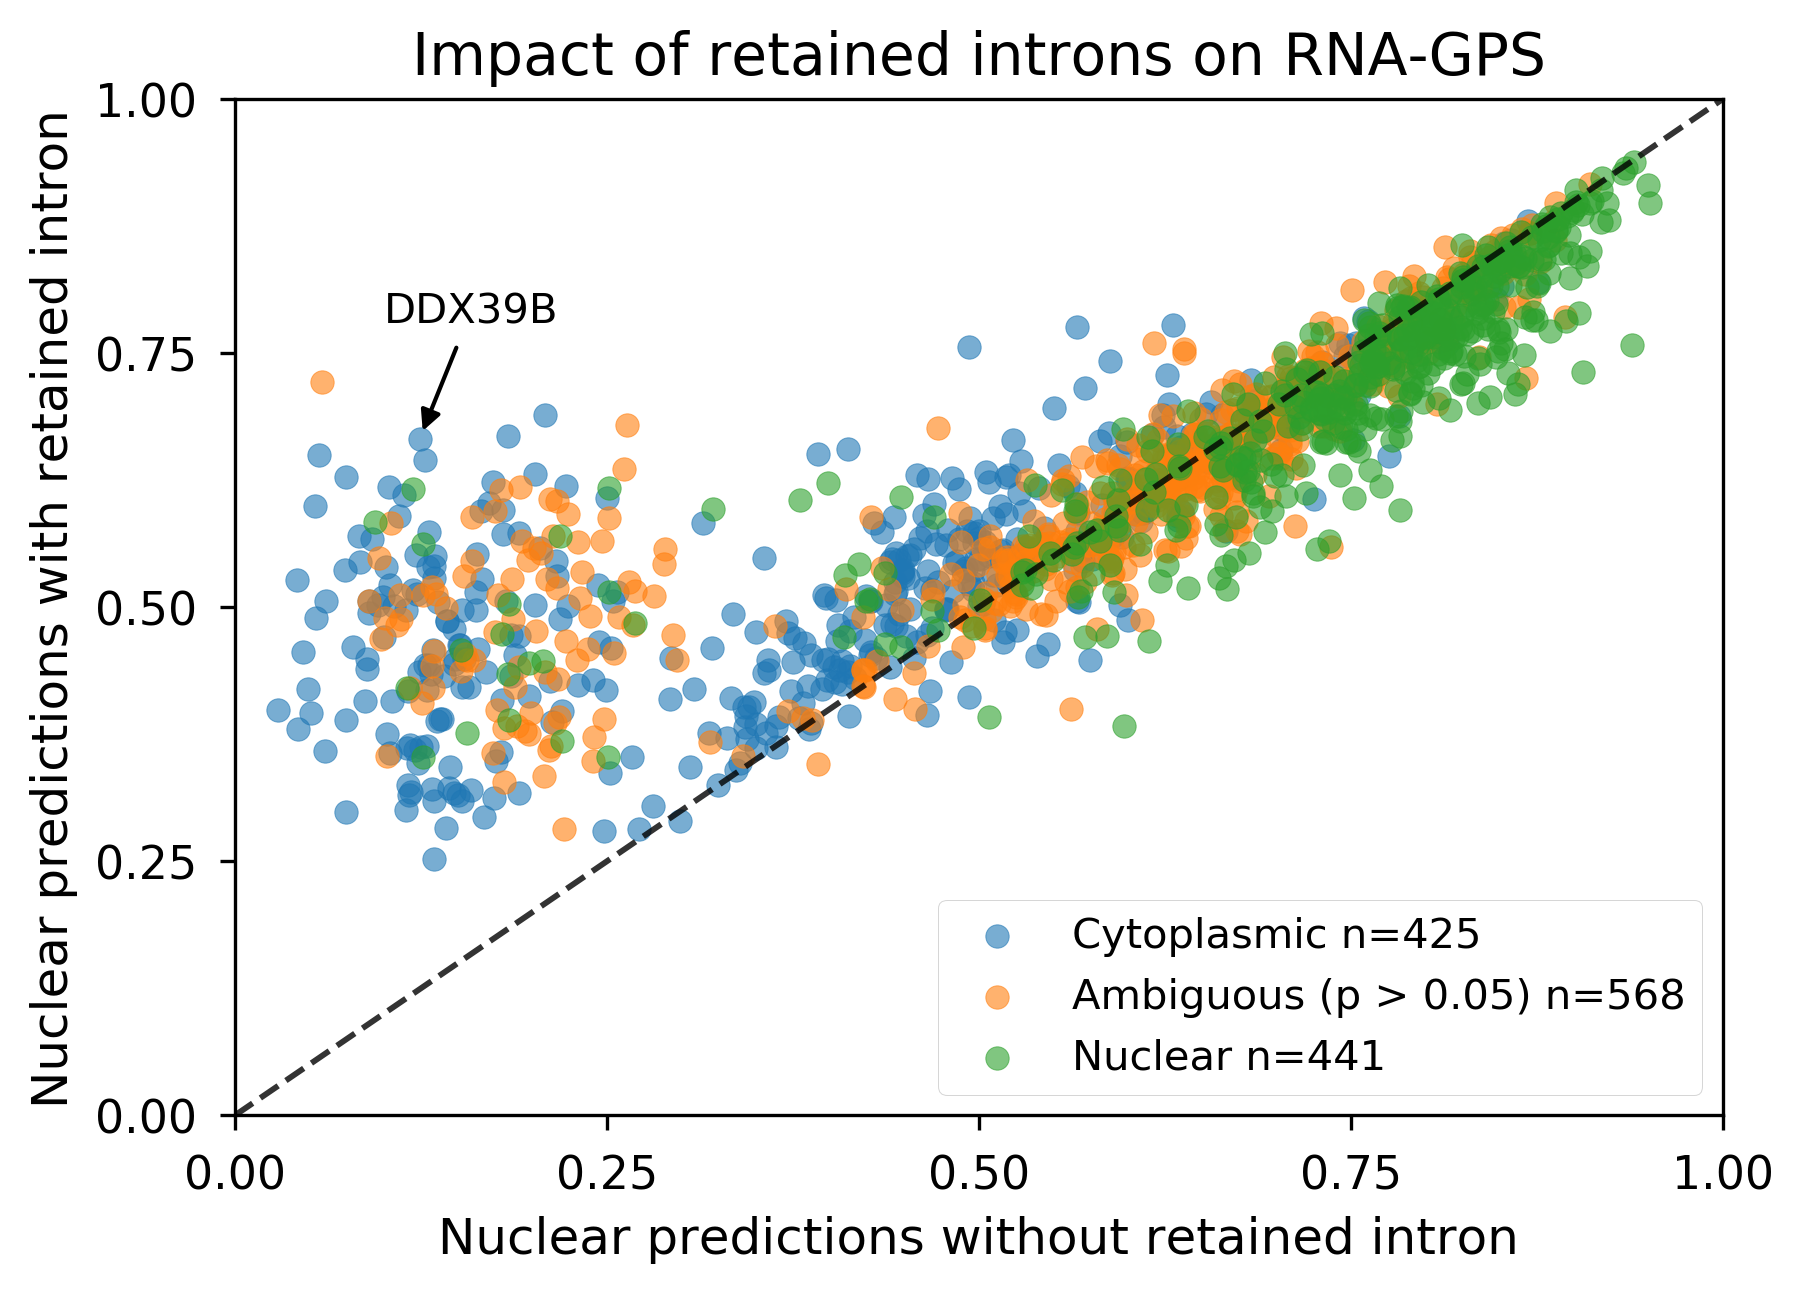

In [79]:
fig, ax = plt.subplots(dpi=300)
for i in [-1, 0, 1]:
    cat_count = np.sum(ri_labels == i)
    ax.scatter(
        ri_preds_no_intron[np.where(ri_labels == i)],
        ri_preds_with_intron[np.where(ri_labels == i)],
        alpha=0.6,
        label=['Cytoplasmic', 'Ambiguous (p > 0.05)', 'Nuclear'][i+1] + f" n={cat_count}",
    )
ax.plot((0, 1), (0, 1), color='black', linestyle='--', alpha=0.8)
ax.annotate(
    'DDX39B',
    (ri_preds_no_intron[example_idx], ri_preds_with_intron[example_idx]),
    (0.1, 0.78),
    arrowprops={
        "arrowstyle": "-|>",
        "lw": 1,
        "facecolor": "black",
    }
)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    xticks=np.arange(0, 1.1, 0.25),
    yticks=np.arange(0, 1.1, 0.25),
    xlabel="Nuclear predictions without retained intron",
    ylabel="Nuclear predictions with retained intron",
    title="Impact of retained introns on RNA-GPS",
)
ax.legend(loc='lower right')
# ax.set_aspect('equal', 'box')
fig.savefig(os.path.join(PLOT_DIR, "retained_intron_scatter_colored.pdf"), dpi=1200)
fig.show()

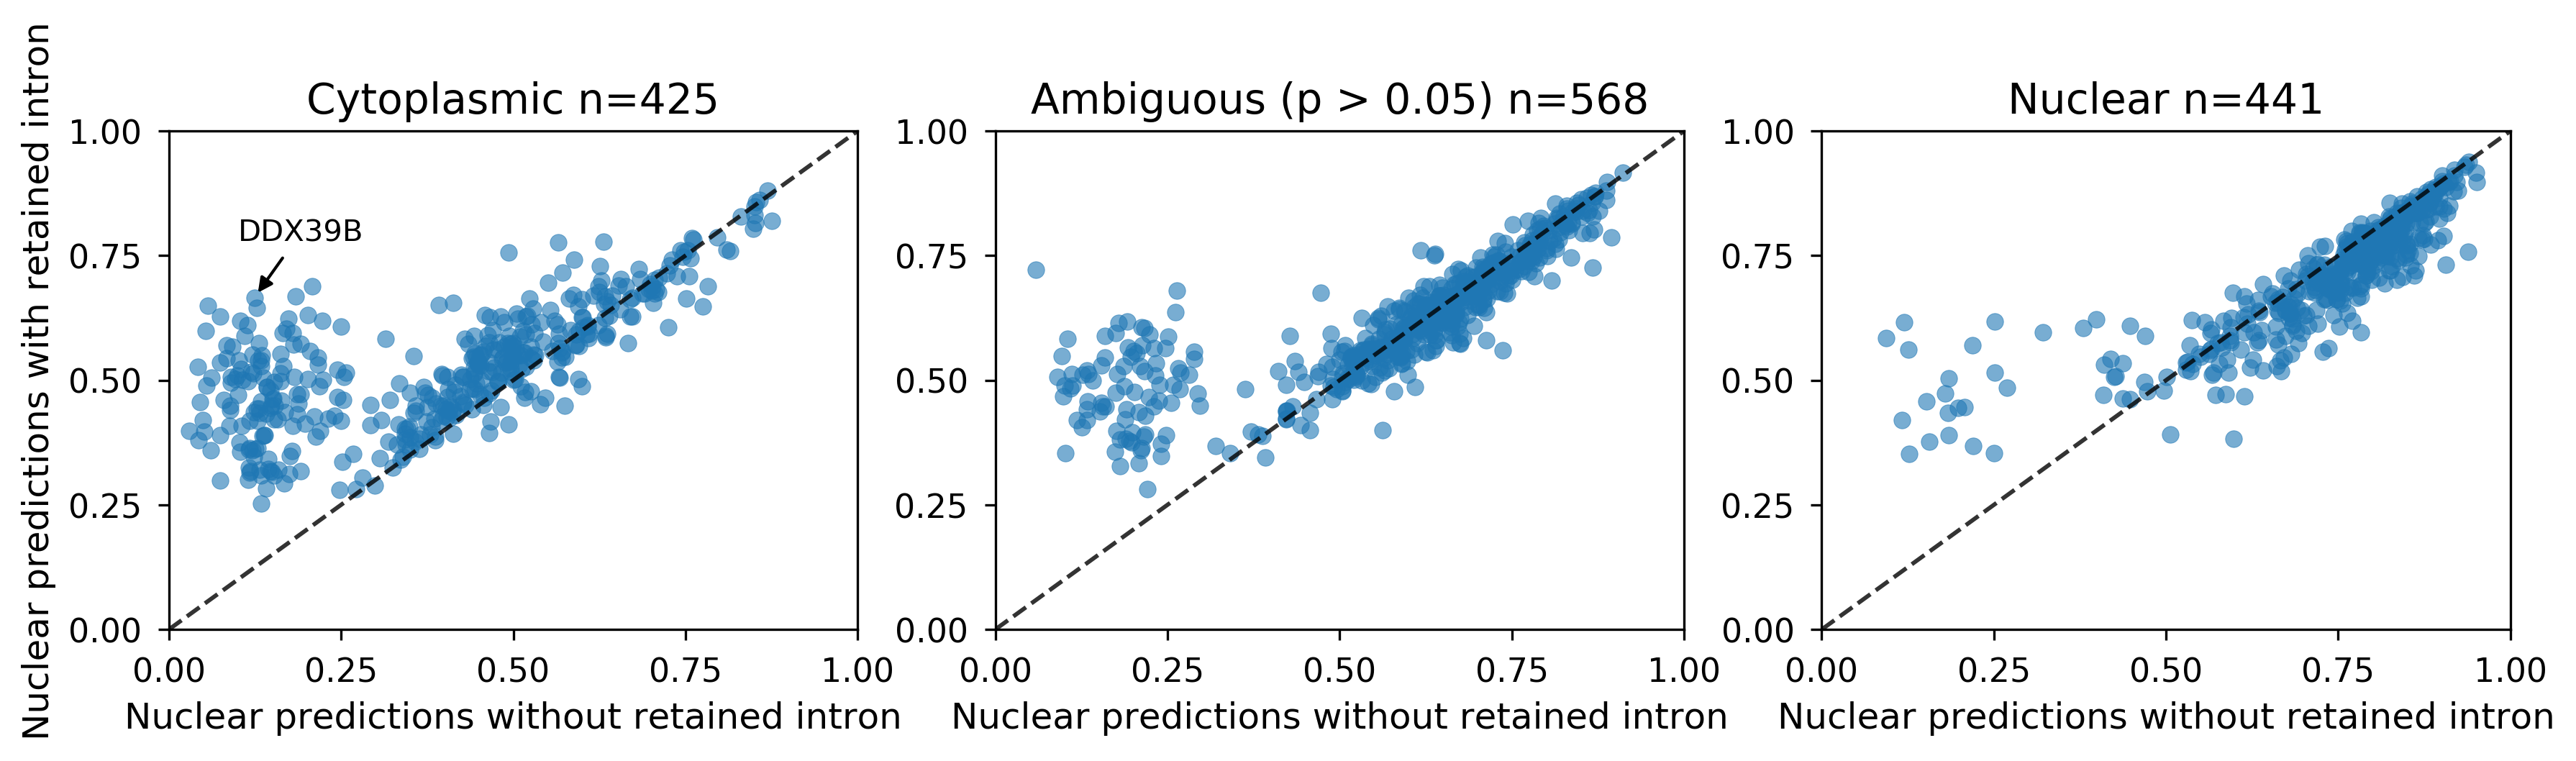

In [228]:
fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(14, 3))
for i, ax in zip([-1, 0, 1], axes):
    cat_count = np.sum(ri_labels == i)
    ax.scatter(
        ri_preds_no_intron[np.where(ri_labels == i)],
        ri_preds_with_intron[np.where(ri_labels == i)],
        alpha=0.6,
    )
    ax.plot((0, 1), (0, 1), color='black', linestyle='--', alpha=0.8)
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        xticks=np.arange(0, 1.1, 0.25),
        yticks=np.arange(0, 1.1, 0.25),
        xlabel="Nuclear predictions without retained intron",
        ylabel="Nuclear predictions with retained intron" if i == -1 else None,
        title=['Cytoplasmic', 'Ambiguous (p > 0.05)', 'Nuclear'][i+1] + f" n={cat_count}"
    )

axes[0].annotate(
    'DDX39B',
    (ri_preds_no_intron[example_idx], ri_preds_with_intron[example_idx]),
    (0.1, 0.78),
    arrowprops={
        "arrowstyle": "-|>",
        "lw": 1,
        "facecolor": "black",
    }
)
fig.savefig(os.path.join(PLOT_DIR, "retained_intron_scatter_3panel.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

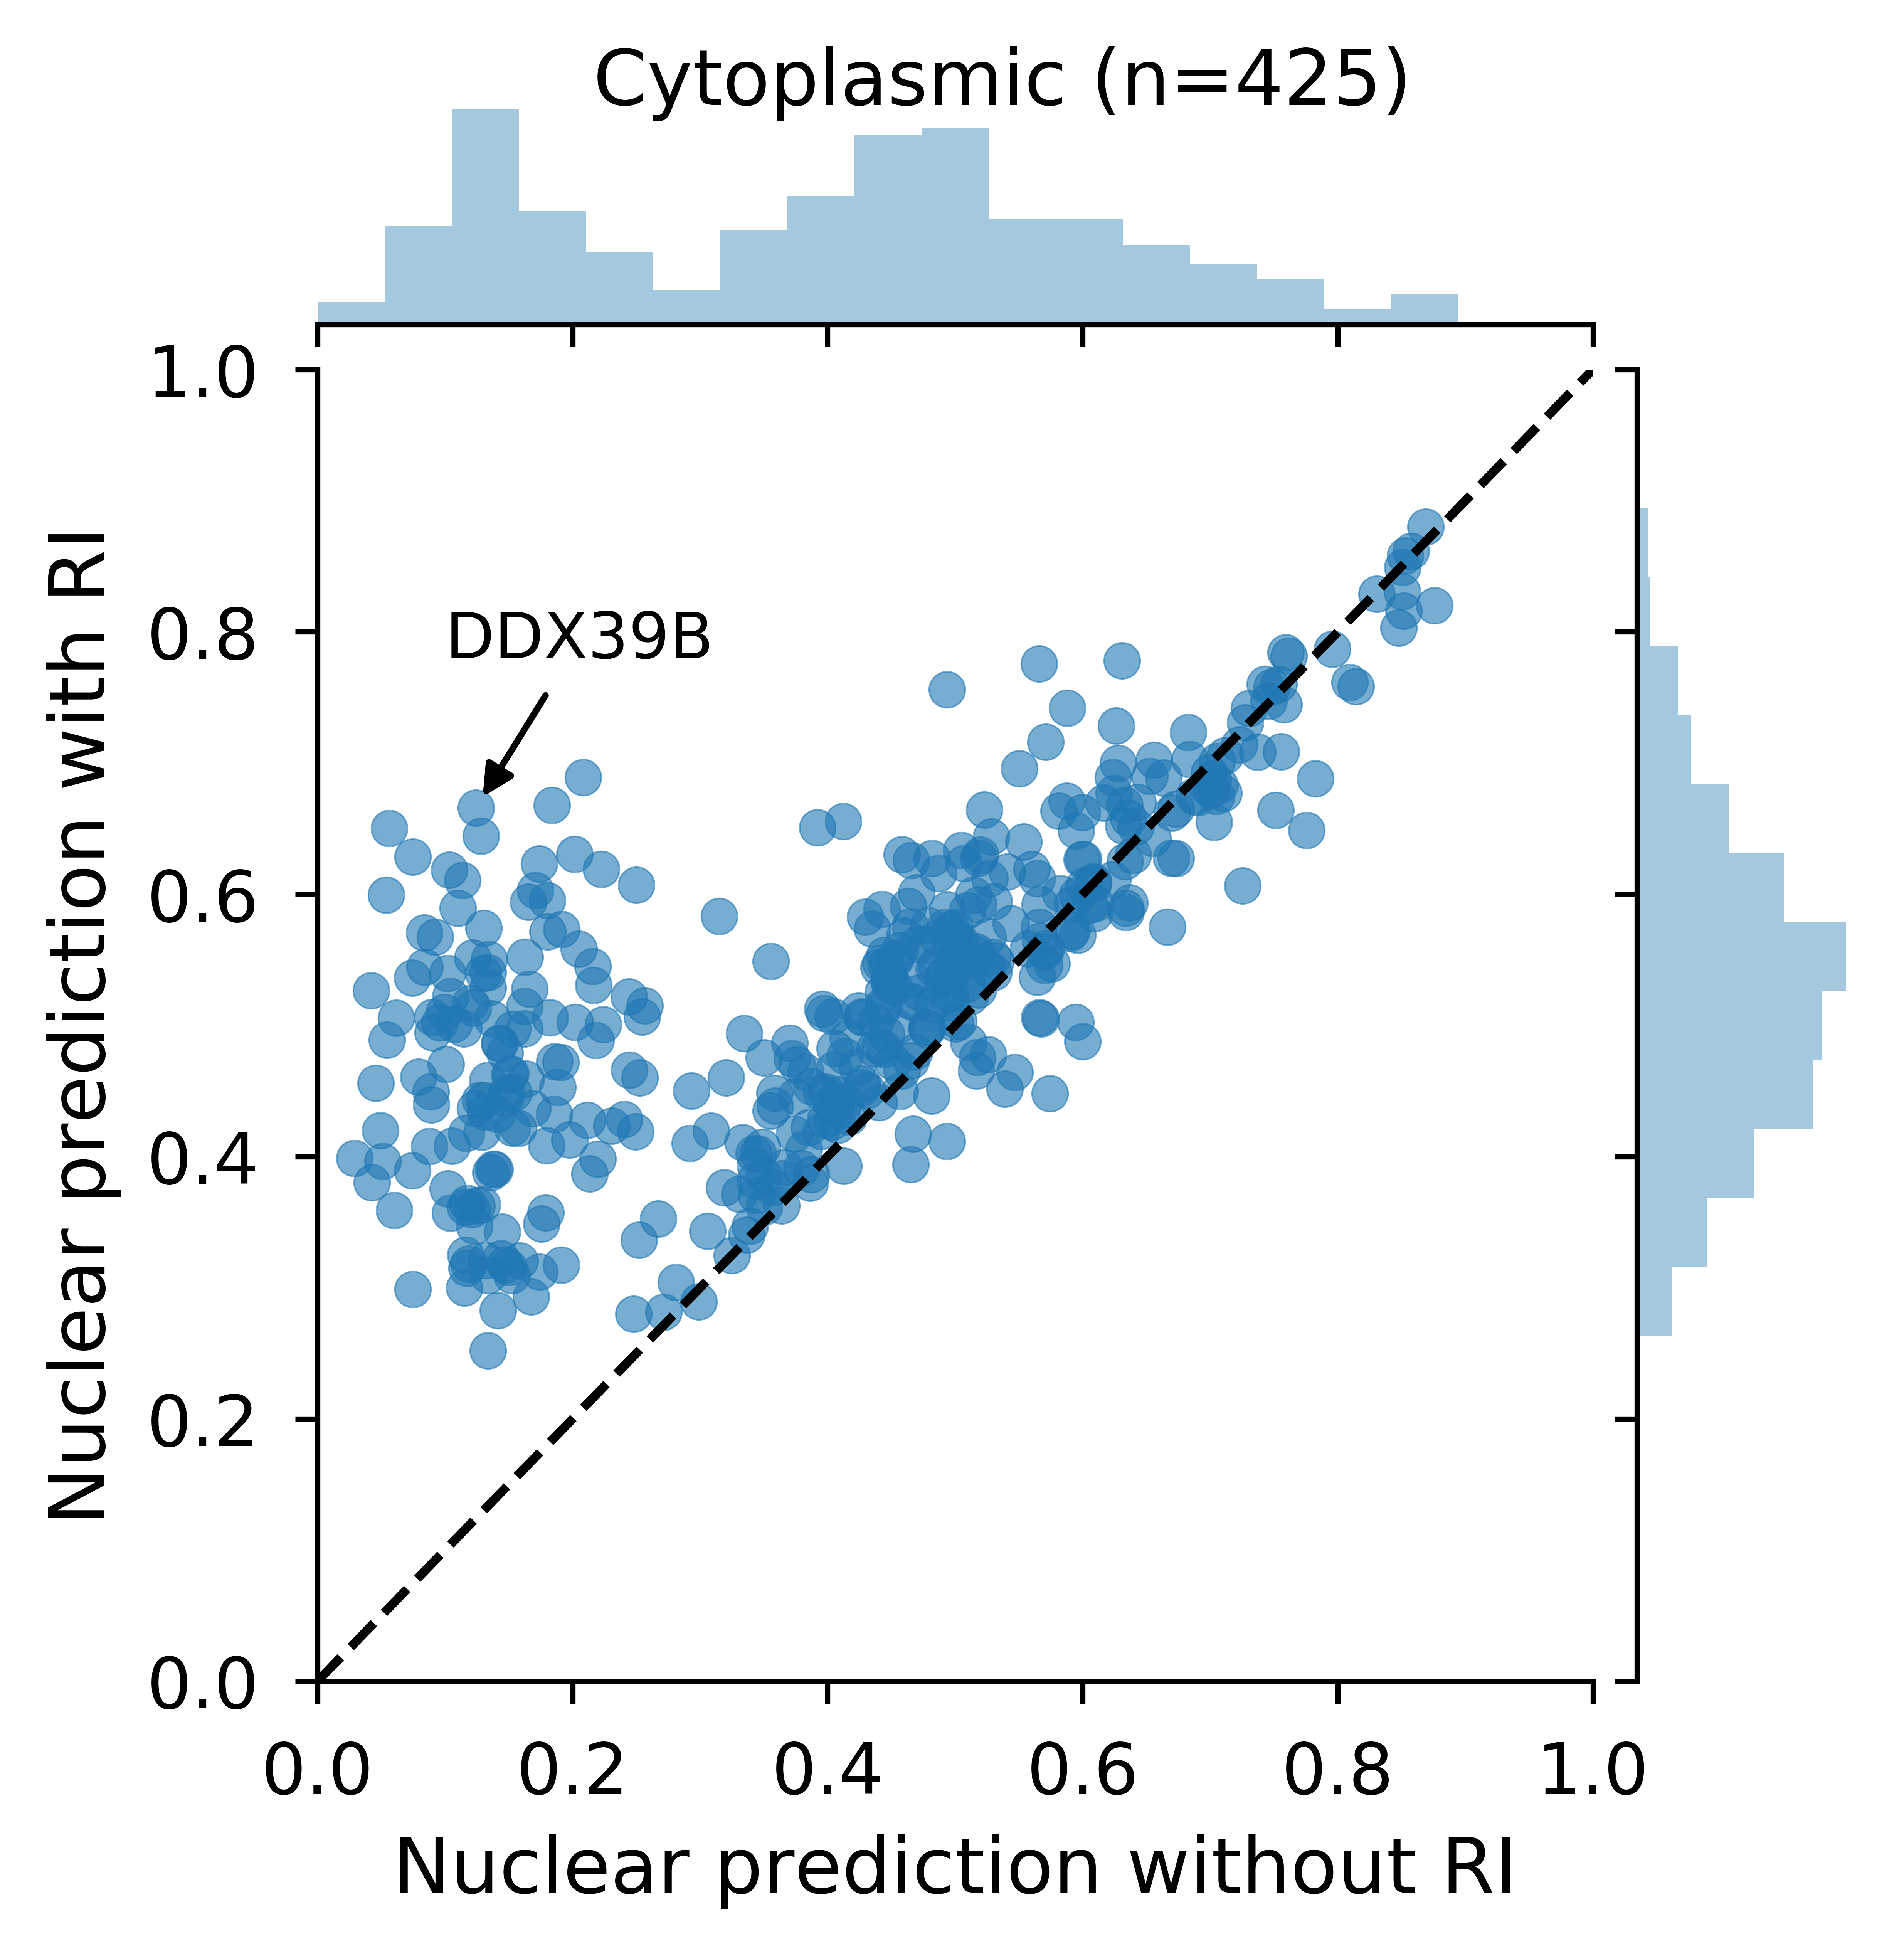

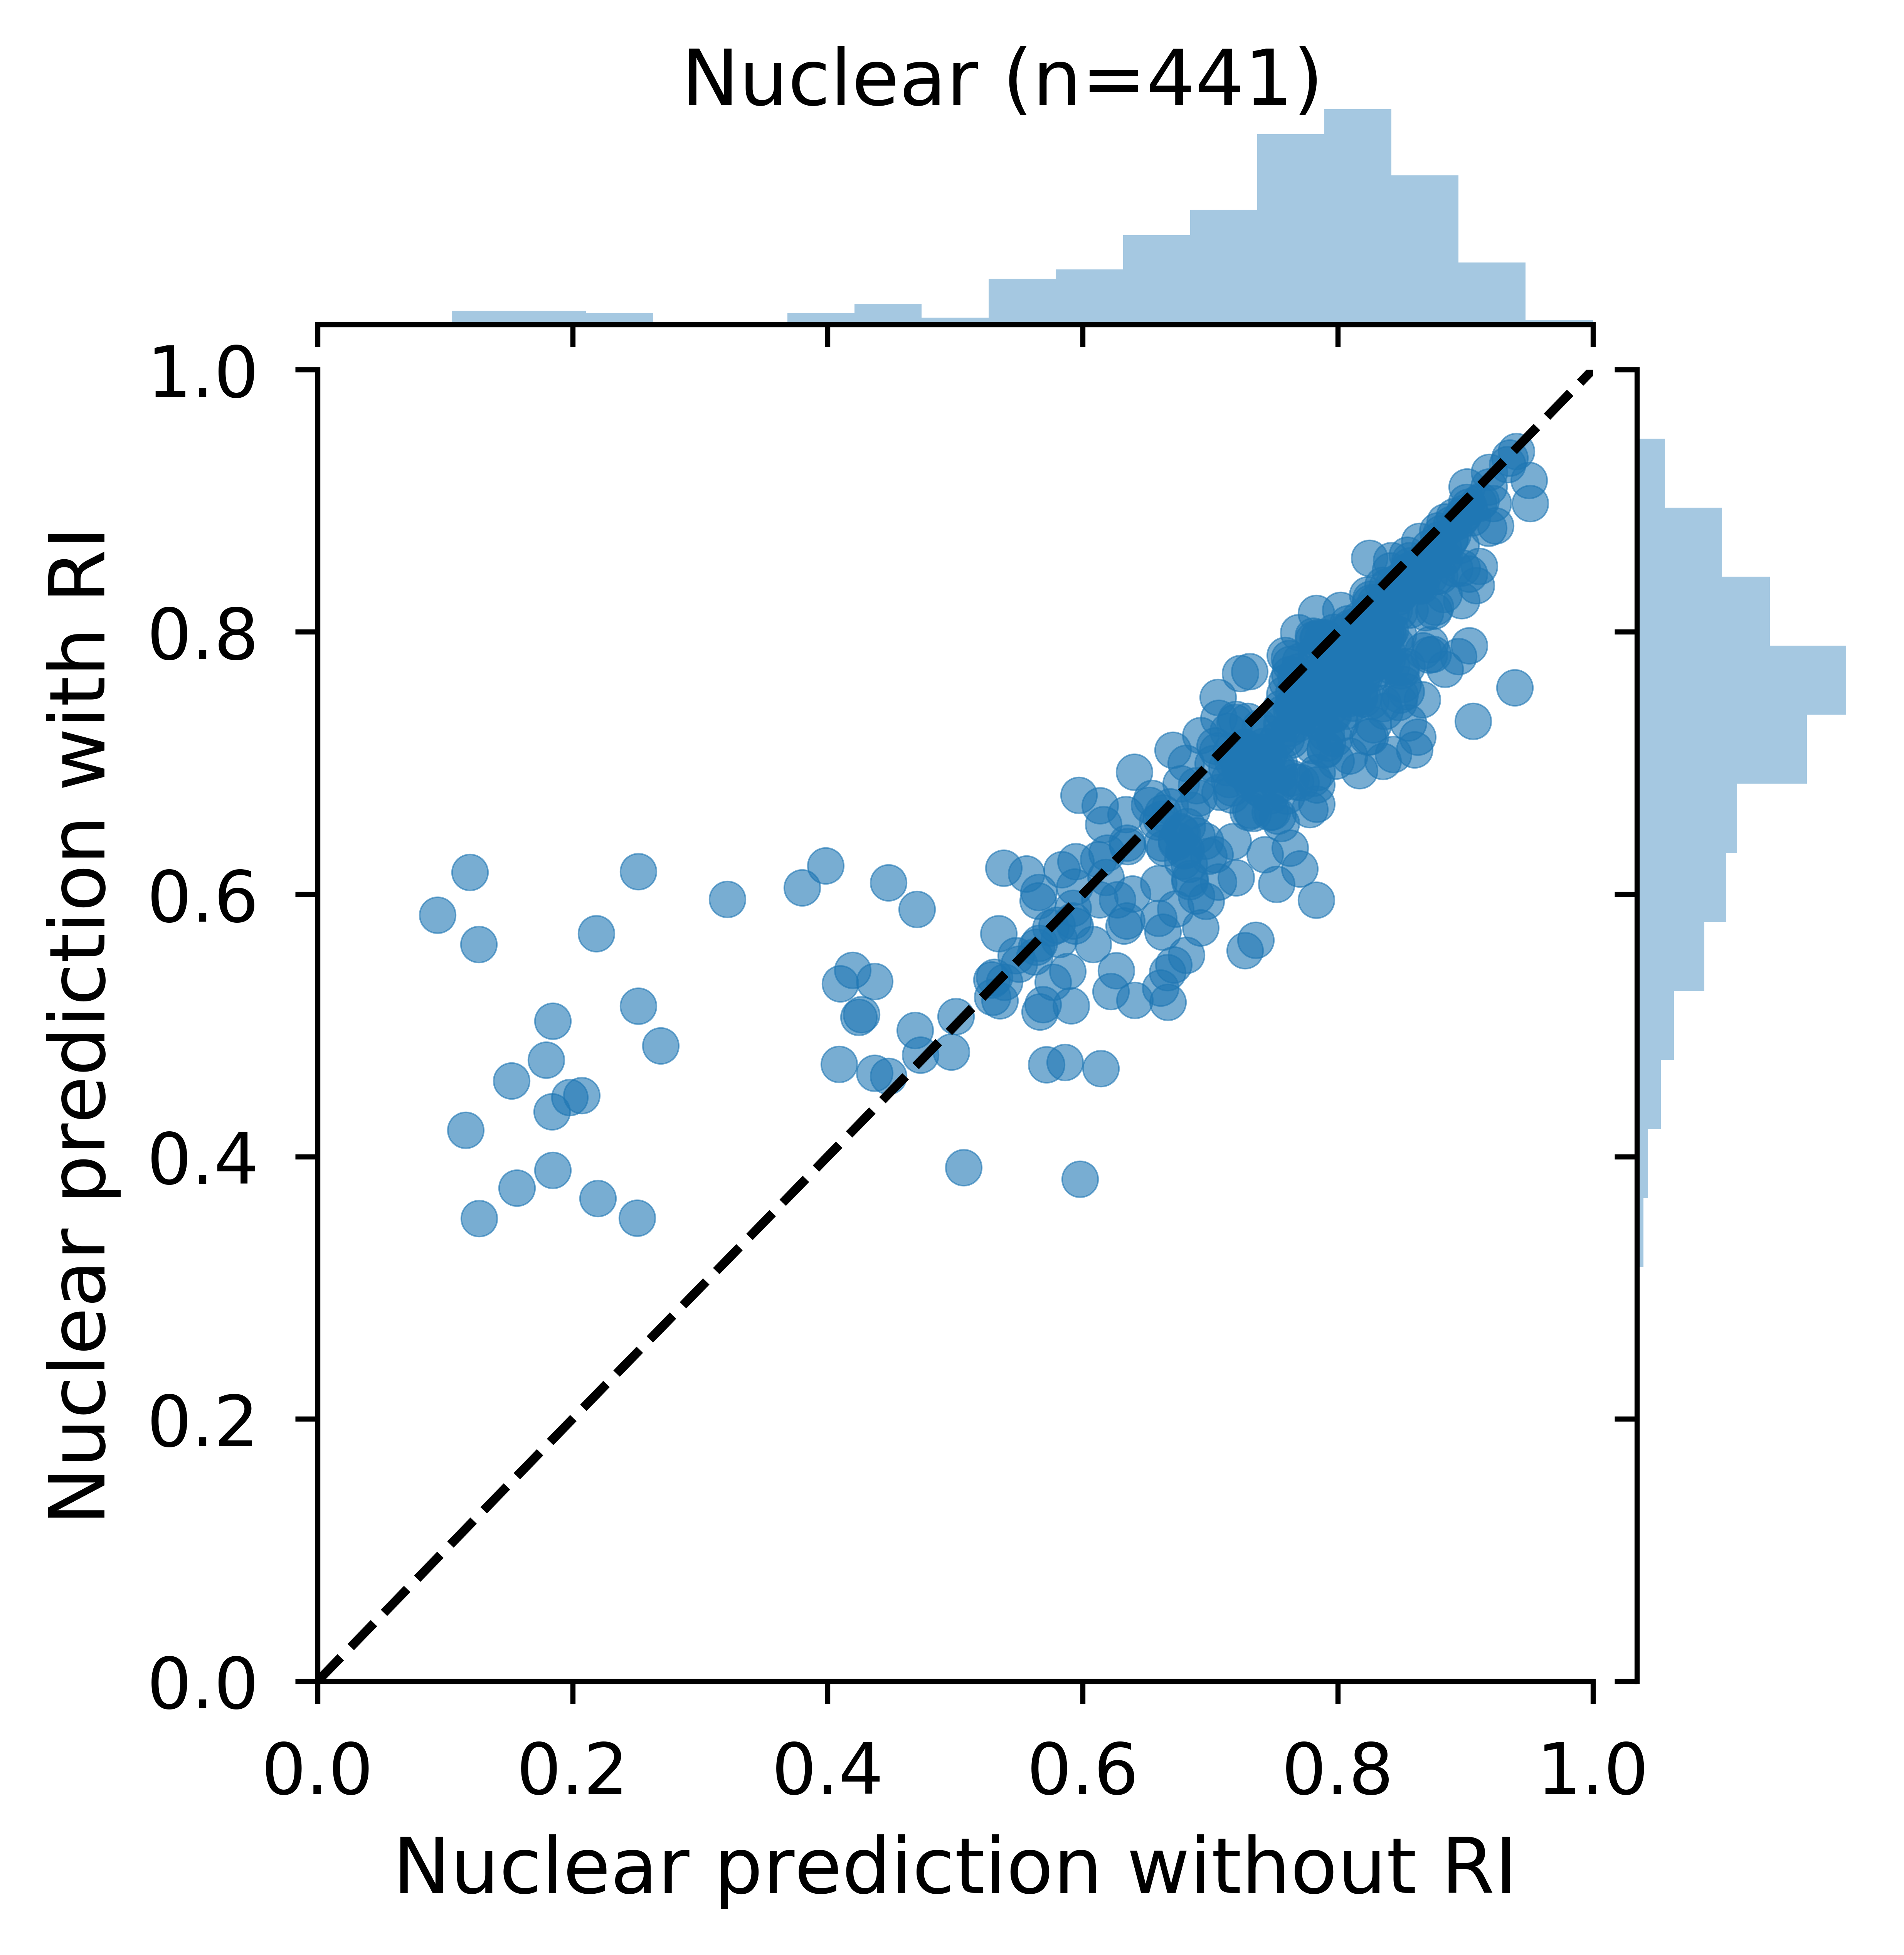

In [263]:
# Plot by logfc AND pval
# fig, axes = plt.subplots(dpi=300, ncols=2, figsize=(9, 3))
# for i, ax in zip([-1, 1], axes):
for i in [-1, 1]:
    cat_count = np.sum(ri_labels == i)
    jp = sns.jointplot(
        ri_preds_no_intron[np.where(ri_labels == i)],
        ri_preds_with_intron[np.where(ri_labels == i)],
        alpha=0.6,
        kind='scatter',
        xlim=(0, 1),
        ylim=(0, 1),
        marginal_kws=dict(bins=np.linspace(0, 1.0, num=20)),
        height=4,
    )
    jp.ax_joint.plot((0, 1), (0, 1), color='black', linestyle='--')
    if i == -1:
        jp.ax_joint.annotate(
            'DDX39B',
            (ri_preds_no_intron[example_idx], ri_preds_with_intron[example_idx]),
            (0.1, 0.78),
            arrowprops={
                "arrowstyle": "-|>",
                "lw": 1,
                "facecolor": "black",
            }
        )
    jp.set_axis_labels("Nuclear prediction without RI", "Nuclear prediction with RI")
    compartment = ['Cytoplasmic', '', 'Nuclear'][i+1]
    title = compartment + f" (n={cat_count})"
    jp.fig.suptitle(title, y=0.99)
    jp.savefig(os.path.join(PLOT_DIR, f"retained_intron_scatter_2panel_{compartment}.pdf"), bbox_inches='tight')

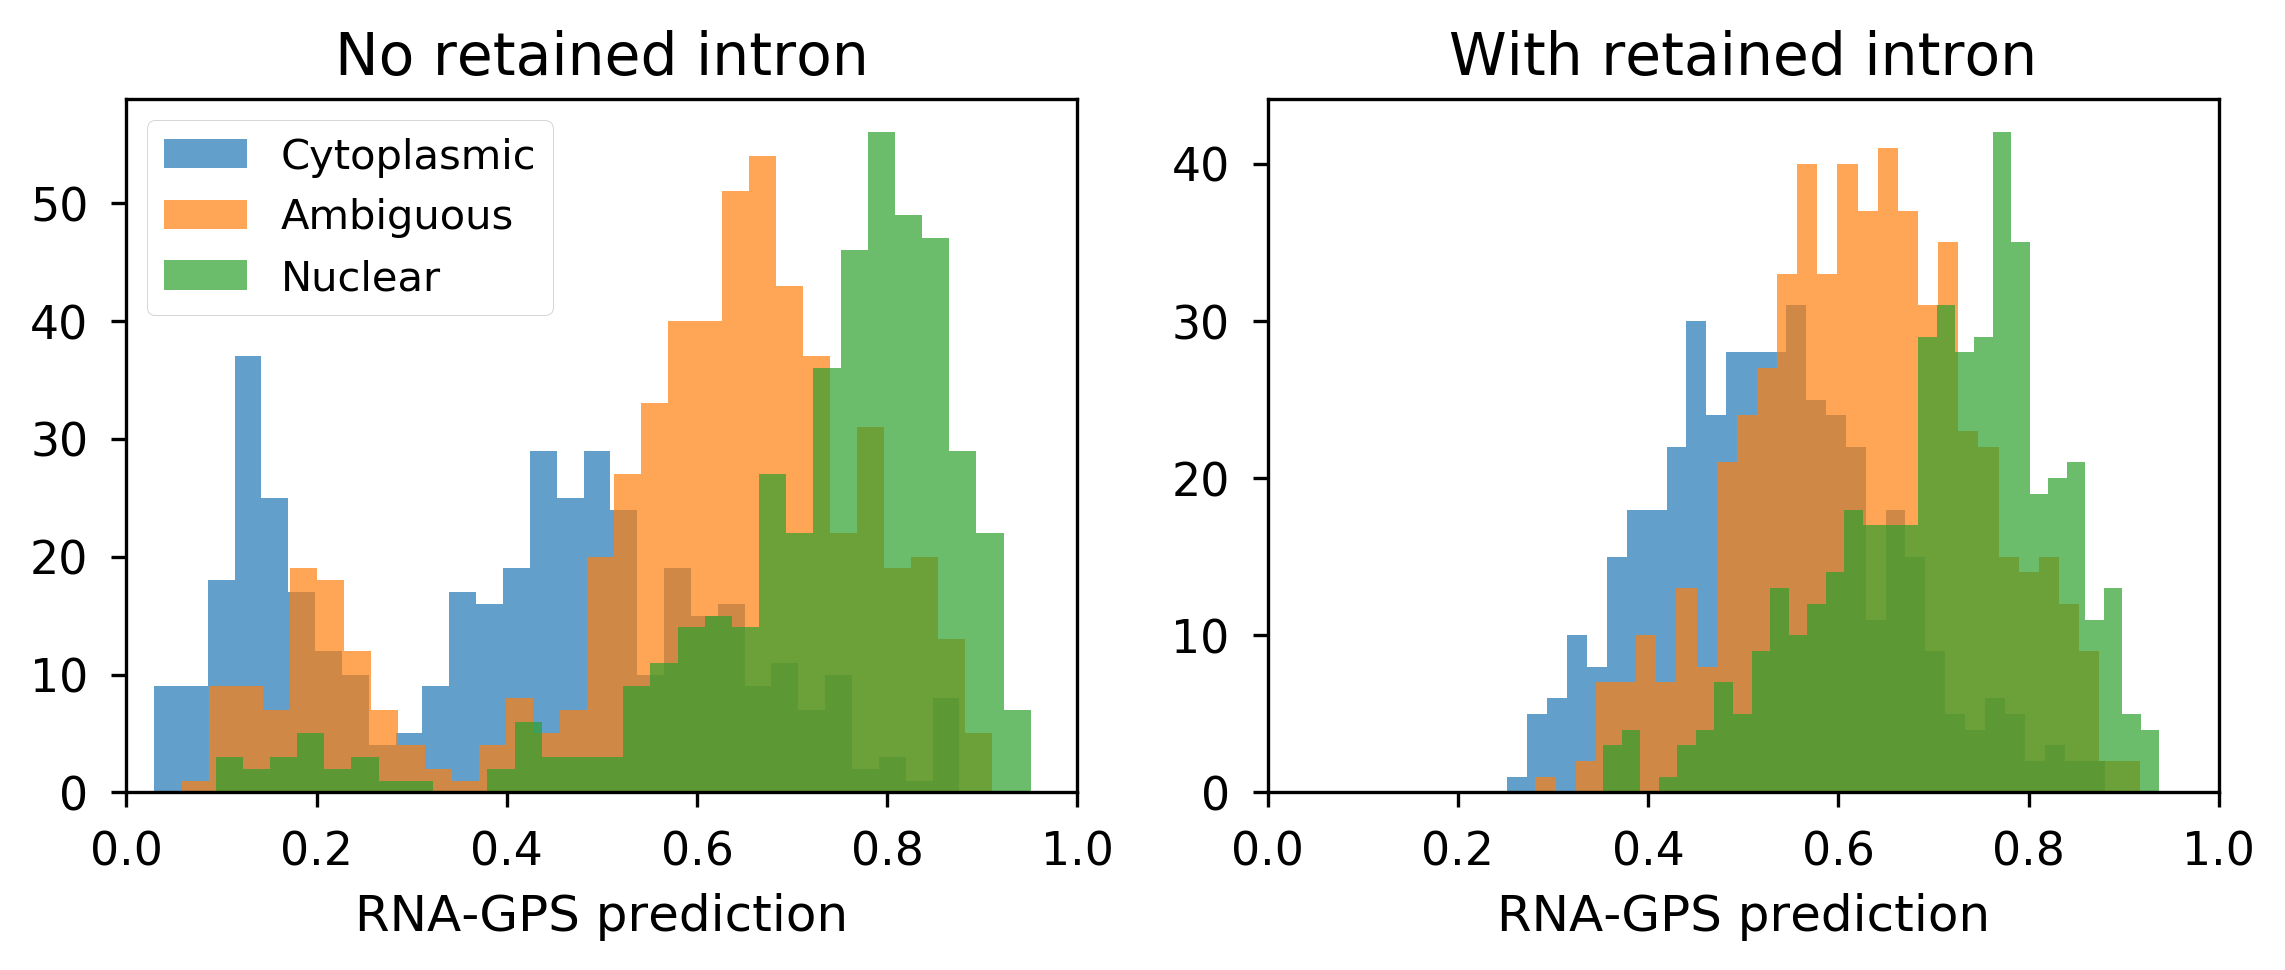

In [45]:
fig, (ax1, ax2) = plt.subplots(dpi=300, ncols=2, figsize=(9, 3))
for i in [-1, 0, 1]:
    alpha = 0.7
    ax1.hist(
        ri_preds_no_intron[np.where(ri_labels == i)],
        alpha=alpha,
        label=['Cytoplasmic', 'Ambiguous', 'Nuclear'][i+1],
        bins=30,
    )
    ax2.hist(
        ri_preds_with_intron[np.where(ri_labels == i)],
        alpha=alpha,
        label=['Cytoplasmic', 'Ambiguous', 'Nuclear'][i+1],
        bins=30,
    )
ax1.set(xlim=(0, 1), xlabel="RNA-GPS prediction", title='No retained intron')
ax2.set(xlim=(0, 1), xlabel="RNA-GPS prediction", title='With retained intron')
ax1.legend()
fig.show()

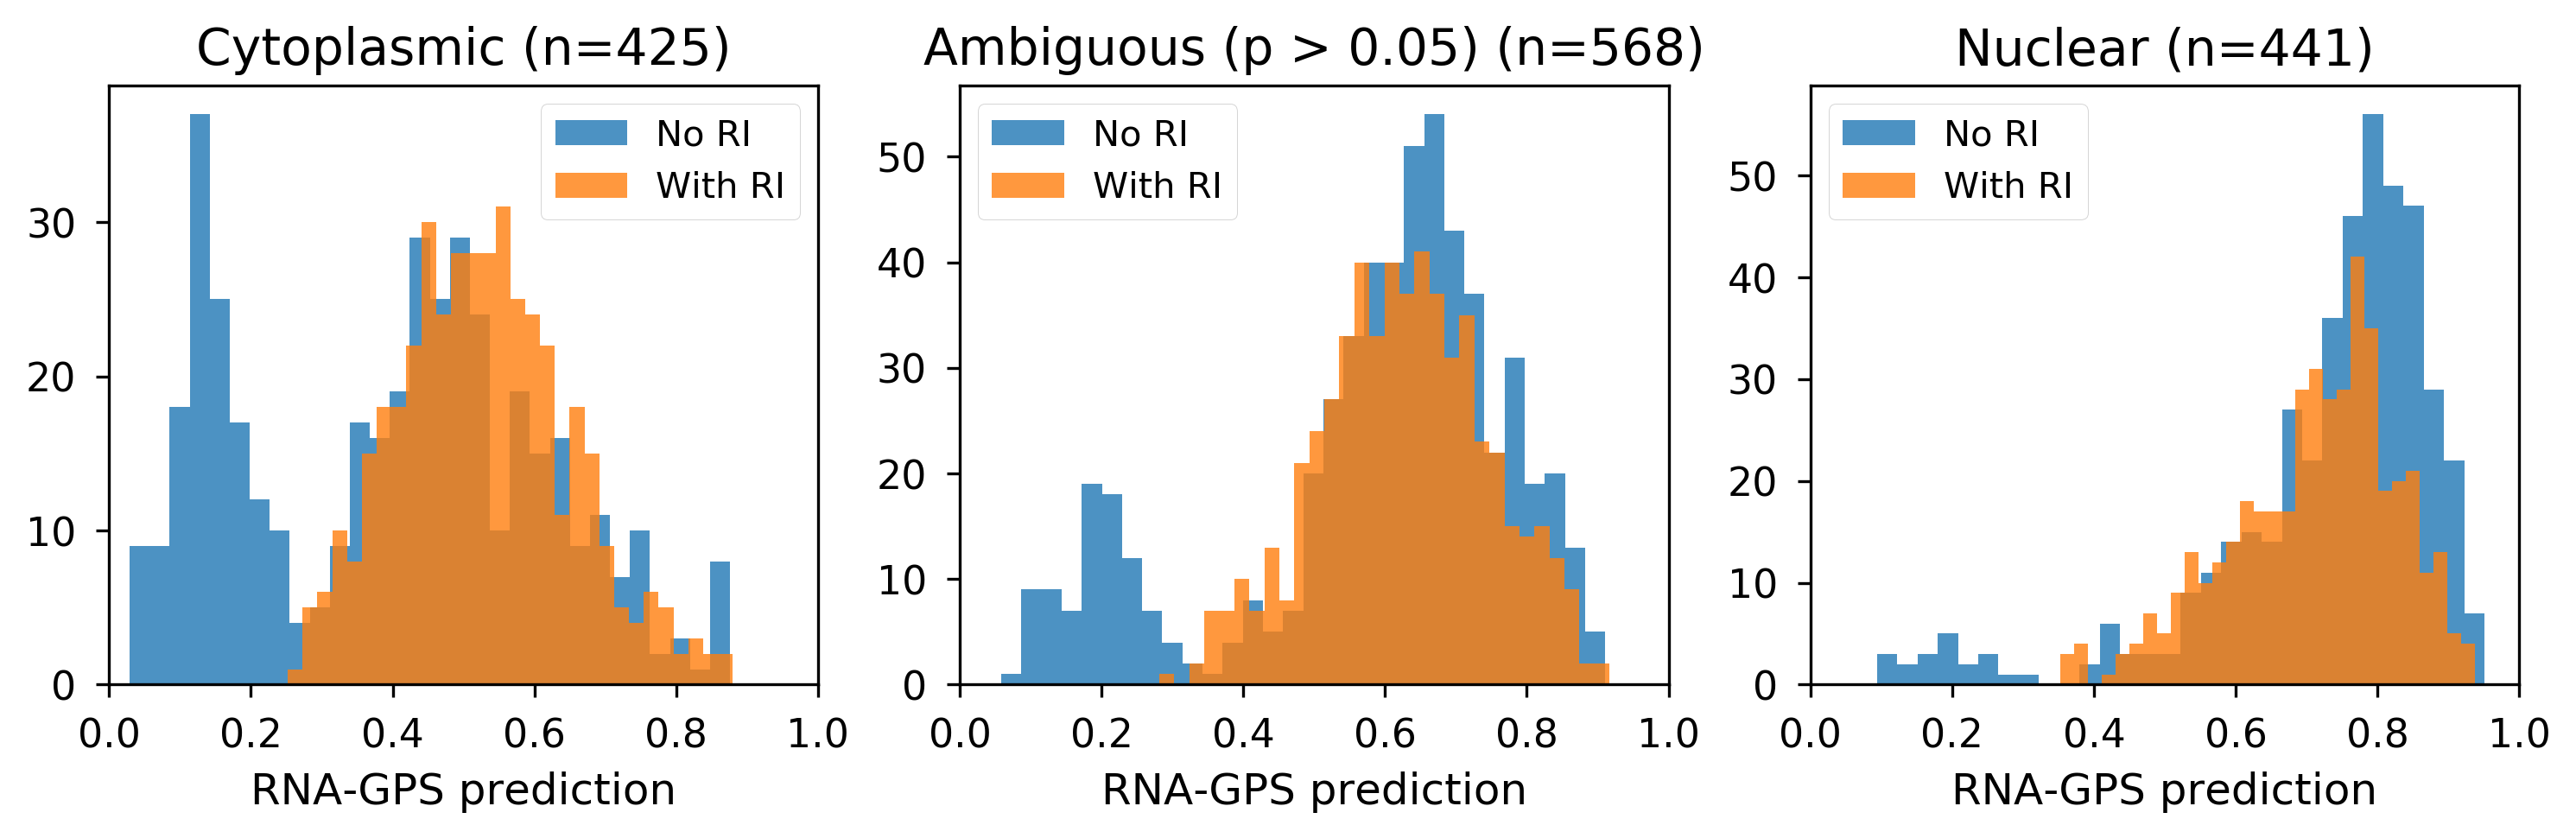

In [51]:
# reverse plotting strategy from above
fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(12, 3))
for i in range(len(axes)):
    alpha=0.8
    ax = axes[i]
    ax.hist(
        ri_preds_no_intron[np.where(ri_labels == i-1)],
        alpha=alpha,
        label="No RI",
        bins=30,
    )
    ax.hist(
        ri_preds_with_intron[np.where(ri_labels == i-1)],
        alpha=alpha,
        label="With RI",
        bins=30,
    )
    ax.legend()
    ax.set(
        title=['Cytoplasmic', 'Ambiguous (p > 0.05)', 'Nuclear'][i] + f" (n={np.sum(ri_labels == i-1)})",
        xlim=(0, 1),
        xlabel=("RNA-GPS prediction"),
    )
fig.savefig(os.path.join(PLOT_DIR, "retained_intron_hist.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

Try to make plot with delta measurement versus delta pred

In [119]:
tpm_with_ri = pd.read_csv(
    os.path.join(data_loader.LOCAL_DATA_DIR, "sleuth_tpm_transcripts_norm_all.txt.gz"),
    sep="\t",
)
# tpm_with_ri = tpm_with_ri.loc[:, ['Nes_target_1', 'Nes_target_2', 'Nls_target_1', 'Nls_target_2']]
# tpm_with_ri = tpm_with_ri.loc[:, ['Nes_control_1', 'Nes_control_2', 'Nes_target_1', 'Nes_target_2', 'Nls_control_1', 'Nls_control_2', 'Nls_target_1', 'Nls_target_2']]
tpm_with_ri.columns

Index(['Erm_control_1', 'Erm_control_2', 'Erm_target_1', 'Erm_target_2',
       'Kdel_control_1', 'Kdel_control_2', 'Kdel_target_1', 'Kdel_target_2',
       'Lma_control_1', 'Lma_control_2', 'Lma_target_1', 'Lma_target_2',
       'Mito_control_1', 'Mito_control_2', 'Mito_target_1', 'Mito_target_2',
       'Nes_control_1', 'Nes_control_2', 'Nes_target_1', 'Nes_target_2',
       'Nik_control_1', 'Nik_control_2', 'Nik_target_1', 'Nik_target_2',
       'Nls_control_1', 'Nls_control_2', 'Nls_target_1', 'Nls_target_2',
       'NucPore_control_1', 'NucPore_control_2', 'NucPore_target_1',
       'NucPore_target_2', 'Omm_control_1', 'Omm_control_2', 'Omm_target_1',
       'Omm_target_2'],
      dtype='object')

In [120]:
tpm_with_ri_only = tpm_with_ri[[trans.endswith("_retained_intron") for trans in tpm_with_ri.index]]
tpm_with_ri_only.head()

Erm_control_1  Erm_control_2  \
ENST00000000233.9_retained_intron        3.674805       2.594132   
ENST00000002125.8_retained_intron        1.506267       2.418944   
ENST00000005340.9_retained_intron        0.035163       0.000000   
ENST00000007699.9_retained_intron        0.275208       0.000000   
ENST00000009041.11_retained_intron       0.000000       0.000000   

                                    Erm_target_1  Erm_target_2  \
ENST00000000233.9_retained_intron       0.051429      0.000000   
ENST00000002125.8_retained_intron       0.000000      0.000000   
ENST00000005340.9_retained_intron       0.000000      0.000000   
ENST00000007699.9_retained_intron       0.000000      0.000000   
ENST00000009041.11_retained_intron      0.000000      0.013768   

                                    Kdel_control_1  Kdel_control_2  \
ENST00000000233.9_retained_intron         1.317049        4.054847   
ENST00000002125.8_retained_intron         0.583525        2.047499   
ENST00000005340.9_retained_intron         0.132277        0.000000   
ENST00000007699.9_retained_intron         0.000000        0.000000   
ENST00000009041.11_retained_intron        0.027357        0.016297   

                                    Kdel_target_1  Kdel_target_2  \
ENST00000000233.9_retained_intron        1.429724       1.998568   
ENST00000002125.8_retained_intron        0.659145       1.094386   
ENST00000005340.9_retained_intron        0.271662       0.316500   
ENST00000007699.9_retained_intron        0.195126       0.089242   
ENST00000009041.11_retained_intron       0.029278       0.053425   

                                    Lma_control_1  Lma_control_2  ...  \
ENST00000000233.9_retained_intron        0.054273       3.043105  ...   
ENST00000002125.8_retained_intron        3.028444       1.613636  ...   
ENST00000005340.9_retained_intron        0.000000       0.000000  ...   
ENST00000007699.9_retained_intron        0.780537       0.000000  ...   
ENST00000009041.11_retained_intron       0.028981       0.069201  ...   

                                    Nls_target_1  Nls_target_2  \
ENST00000000233.9_retained_intron       4.470008      2.746886   
ENST00000002125.8_retained_intron       4.851184      6.562453   
ENST00000005340.9_retained_intron       2.472445      0.828842   
ENST00000007699.9_retained_intron       0.686406      0.604814   
ENST00000009041.11_retained_intron      1.572534      0.825575   

                                    NucPore_control_1  NucPore_control_2  \
ENST00000000233.9_retained_intron            0.000000           1.541818   
ENST00000002125.8_retained_intron            0.000000           0.633948   
ENST00000005340.9_retained_intron            5.974730           0.435716   
ENST00000007699.9_retained_intron            0.000000           0.000000   
ENST00000009041.11_retained_intron           0.013143           0.073907   

                                    NucPore_target_1  NucPore_target_2  \
ENST00000000233.9_retained_intron           0.000000          4.950300   
ENST00000002125.8_retained_intron           0.045588          2.473454   
ENST00000005340.9_retained_intron           0.041530          2.005545   
ENST00000007699.9_retained_intron           0.000000          0.000000   
ENST00000009041.11_retained_intron          0.000000          0.011370   

                                    Omm_control_1  Omm_control_2  \
ENST00000000233.9_retained_intron        0.811550       0.000000   
ENST00000002125.8_retained_intron        3.553279       0.000000   
ENST00000005340.9_retained_intron        0.019857       2.509966   
ENST00000007699.9_retained_intron        0.000000       0.000000   
ENST00000009041.11_retained_intron       0.513215       0.012077   

                                    Omm_target_1  Omm_target_2  
ENST00000000233.9_retained_intron       0.000000      0.232164  
ENST00000002125.8_retained_intron       0.030926      0.358771  
ENST00000005340.9_retained_intron       0.031172      0.62

In [122]:
# print([trans_name.split("_", 1) for trans_name in tpm_with_ri_only.index])
tpm_with_ri_ref = tpm_with_ri.loc[[trans_name.split("_", 1)[0] for trans_name in tpm_with_ri_only.index]]
assert tpm_with_ri_ref.shape == tpm_with_ri_only.shape
tpm_with_ri_ref.head()

Erm_control_1  Erm_control_2  Erm_target_1  Erm_target_2  \
ENST00000000233.9      135.310505     156.065923    152.336533     86.994584   
ENST00000002125.8       15.529140      10.431460      9.066307      8.026181   
ENST00000005340.9       36.547515      31.332072     38.889270     30.896869   
ENST00000007699.9        0.000000       0.000000      0.000000      0.000000   
ENST00000009041.11      48.679783      53.985927     20.903678     45.577208   

                    Kdel_control_1  Kdel_control_2  Kdel_target_1  \
ENST00000000233.9       178.868972      187.836078     218.473285   
ENST00000002125.8        10.694208        9.448193       8.777256   
ENST00000005340.9        40.809798       36.014047      42.118448   
ENST00000007699.9         0.287668        0.000000       0.367109   
ENST00000009041.11       38.655056       46.799444      39.656585   

                    Kdel_target_2  Lma_control_1  Lma_control_2  ...  \
ENST00000000233.9      154.378148     203.403806     187.451318  ...   
ENST00000002125.8       10.517804      10.501173      17.617891  ...   
ENST00000005340.9       34.318948      37.682599      56.837936  ...   
ENST00000007699.9        0.099959       0.000000       0.000000  ...   
ENST00000009041.11      41.322934      41.418433      29.059982  ...   

                    Nls_target_1  Nls_target_2  NucPore_control_1  \
ENST00000000233.9     105.405888    102.476453         142.394403   
ENST00000002125.8      16.186933     14.898229          15.094500   
ENST00000005340.9      28.946627     33.397313          35.251703   
ENST00000007699.9       0.861875      1.491276           0.000000   
ENST00000009041.11     24.595065     35.407183          39.769682   

                    NucPore_control_2  NucPore_target_1  NucPore_target_2  \
ENST00000000233.9          189.485647        179.575813        135.885693   
ENST00000002125.8           10.858993          9.936016         13.417477   
ENST00000005340.9           51.806179         74.804125         36.093334   
ENST00000007699.9            0.096949          6.112141          2.490607   
ENST00000009041.11          41.998233         46.159187         47.862553   

                    Omm_control_1  Omm_control_2  Omm_target_1  Omm_target_2  
ENST00000000233.9       96.913139     137.397471    134.581373    143.289352  
ENST00000002125.8       11.123085       9.781421      5.919390     10.109434  
ENST00000005340.9       28.879296      37.449341     23.747317     33.599883  
ENST00000007699.9        0.000000       0.000000      0.000000      1.151512  
ENST00000009041.11      43.038832      38.484280     68.258181     49.043788  

[5 rows x 36 columns]

In [153]:
def table_to_logfc(tab):
    """
    """
    retval = pd.DataFrame(
        0,
        index=tab.index,
        columns=data_loader.LOCALIZATIONS,
    )
    for l in data_loader.LOCALIZATIONS:
        target = np.mean(tab.loc[:, [f"{l}_target_1", f"{l}_target_2"]], axis=1)
        control = np.mean(tab.loc[:, [f"{l}_control_1", f"{l}_control_2"]], axis=1)
        logfc = target / control
        retval[l] = np.where(
            np.logical_or(np.logical_or(pd.isna(logfc), np.isinf(logfc)), logfc == 0),
            0, np.log2(logfc),
        )
    return retval

tpm_with_ri_ref_logfc = table_to_logfc(tpm_with_ri_ref)
tpm_with_ri_only_logfc = table_to_logfc(tpm_with_ri_only)

/storage/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app


In [154]:
tpm_with_ri_ref_logfc.head()

Erm       Lma      Mito       Nes       Nik  \
ENST00000000233.9  -0.283876 -1.022363 -0.220035  0.123402 -1.015901   
ENST00000002125.8  -0.602961  0.367684  0.304248 -1.110082  1.203137   
ENST00000005340.9   0.039963 -0.541035  0.165934  0.528989 -0.825846   
ENST00000007699.9   0.000000  0.000000  0.000000  0.000000  0.000000   
ENST00000009041.11 -0.626943  0.090108  0.034435 -0.610846  0.216746   

                         Nls   NucPore       Omm  
ENST00000000233.9  -0.653415 -0.073198  0.245992  
ENST00000002125.8   0.709345 -0.152290 -0.383145  
ENST00000005340.9  -0.646911  0.349179 -0.209909  
ENST00000007699.9   0.000000  6.471429  0.000000  
ENST00000009041.11 -0.595638  0.201460  0.524946

In [155]:
tpm_with_ri_only_logfc.head()

Erm       Lma      Mito       Nes  \
ENST00000000233.9_retained_intron  -6.929501  1.131373  1.500680 -0.495396   
ENST00000002125.8_retained_intron   0.000000  1.484539 -0.589004  0.741814   
ENST00000005340.9_retained_intron   0.000000  0.000000  5.671000 -0.771673   
ENST00000007699.9_retained_intron   0.000000  0.184764  0.000000  0.000000   
ENST00000009041.11_retained_intron  0.000000  4.441831 -3.082595  0.735992   

                                         Nik       Nls   NucPore       Omm  
ENST00000000233.9_retained_intron   0.000000  0.175898  1.682884 -1.805536  
ENST00000002125.8_retained_intron   7.727050  7.068581  1.990439 -3.188723  
ENST00000005340.9_retained_intron  -4.885438  6.816946 -1.646861 -1.948778  
ENST00000007699.9_retained_intron   0.000000  0.000000  0.000000  0.000000  
ENST00000009041.11_retained_intron  5.357703  6.465333 -2.936658 -3.566670

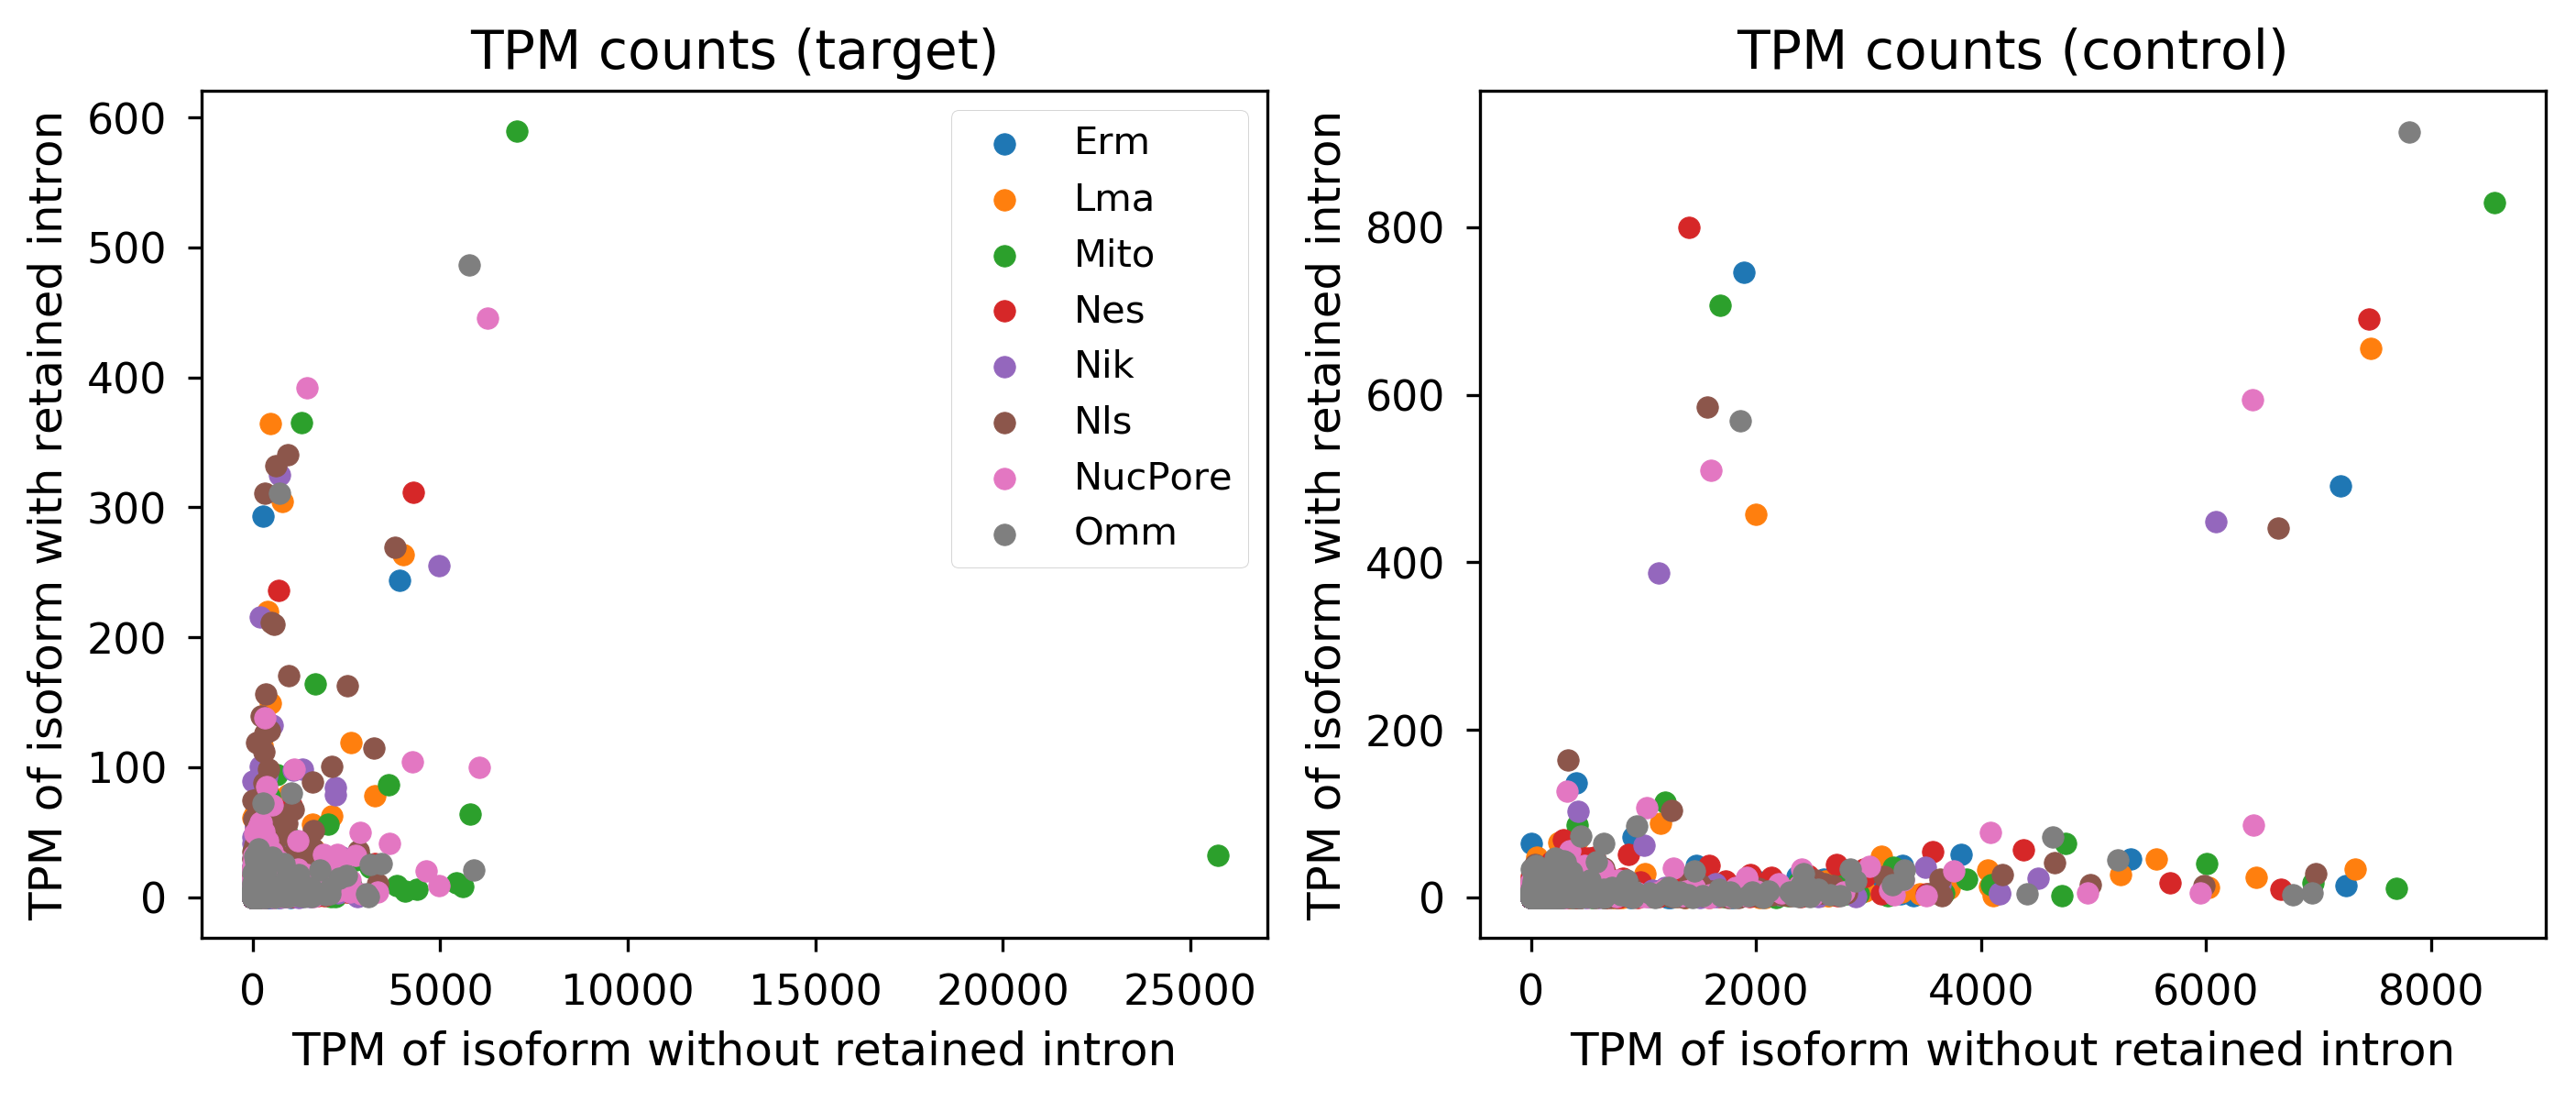

In [156]:
fig, (ax1, ax2) = plt.subplots(dpi=300, ncols=2, figsize=(11, 4))
for l in data_loader.LOCALIZATIONS:
    x = tpm_with_ri_ref.loc[:, [f"{l}_target_1", f"{l}_target_2"]]  # (1434, 2)
    y = tpm_with_ri_only.loc[:, [f"{l}_target_1", f"{l}_target_2"]]
    ax1.scatter(np.mean(x.values, axis=1), np.mean(y.values, axis=1), label=l)
    
    x_ctrl = tpm_with_ri_ref.loc[:, [f"{l}_control_1", f"{l}_control_2"]]  # (1434, 2)
    y_ctrl = tpm_with_ri_only.loc[:, [f"{l}_control_1", f"{l}_control_2"]]
    ax2.scatter(np.mean(x_ctrl.values, axis=1), np.mean(y_ctrl.values, axis=1), label=l)
ax1.legend()
# ax2.legend()
ax1.set(
    title='TPM counts (target)',
    xlabel="TPM of isoform without retained intron",
    ylabel="TPM of isoform with retained intron",
#     xlim=(0, 10000),
)
ax2.set(
    title='TPM counts (control)',
    xlabel="TPM of isoform without retained intron",
    ylabel="TPM of isoform with retained intron",
)
fig.show()

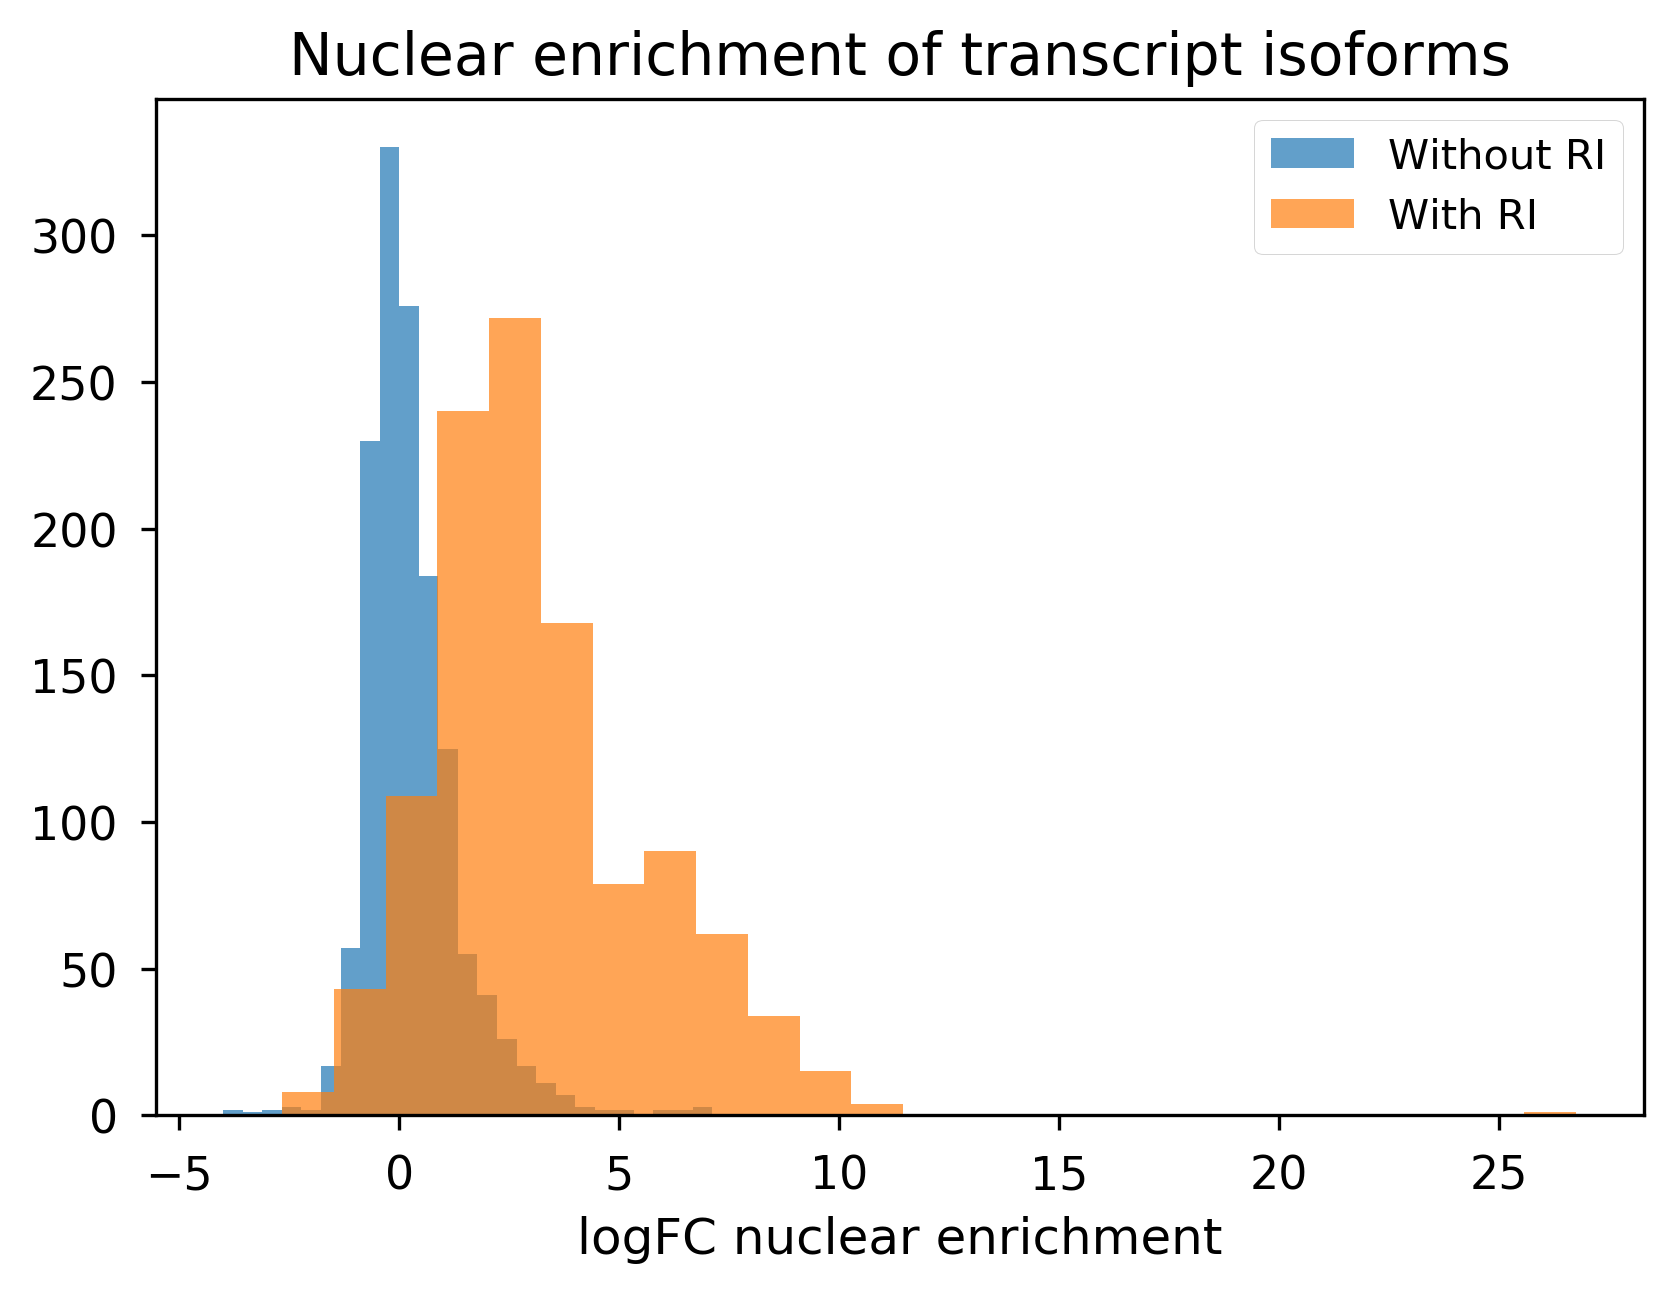

In [165]:
nonzero = lambda x: x[x != 0]
fig, ax = plt.subplots(dpi=300)
ax.hist(nonzero(tpm_with_ri_ref_logfc['Nls']), bins=25, alpha=0.7, label="Without RI")
ax.hist(nonzero(tpm_with_ri_only_logfc['Nls']), bins=25, alpha=0.7, label="With RI")
ax.legend()
ax.set(
    xlabel="logFC nuclear enrichment",
    title="Nuclear enrichment of transcript isoforms",
)
fig.show()

In [171]:
mutual_nonzero_idx = np.where(np.logical_and(
    tpm_with_ri_ref_logfc['Nls'] != 0,
    tpm_with_ri_only_logfc['Nls'] != 0,
))
mutual_nonzero_idx

(array([   0,    1,    2, ..., 1430, 1431, 1432]),)

In [189]:
tpm_with_ri_ref_logfc_nls = tpm_with_ri_ref_logfc.iloc[mutual_nonzero_idx[0], data_loader.LOCALIZATIONS.index('Nls')]
tpm_with_ri_only_logfc_nls = tpm_with_ri_only_logfc.loc[[t + "_retained_intron" for t in list(tpm_with_ri_ref_logfc_nls.index)], "Nls"]
tpm_with_ri_ref_logfc_nls.head()

ENST00000000233.9    -0.653415
ENST00000002125.8     0.709345
ENST00000005340.9    -0.646911
ENST00000009041.11   -0.595638
ENST00000012443.8    -0.206522
Name: Nls, dtype: float64

In [190]:
tpm_with_ri_only_logfc_nls.head()

ENST00000000233.9_retained_intron     0.175898
ENST00000002125.8_retained_intron     7.068581
ENST00000005340.9_retained_intron     6.816946
ENST00000009041.11_retained_intron    6.465333
ENST00000012443.8_retained_intron     7.152742
Name: Nls, dtype: float64

In [205]:
measured_delta = tpm_with_ri_only_logfc_nls.values - tpm_with_ri_ref_logfc_nls.values
measured_delta

array([ 0.82931281,  6.35923621,  7.46385623, ...,  3.52034696,
        0.74533674, -3.42504776])

In [208]:
observed_delta = ri_preds_with_intron_named.loc[tpm_with_ri_ref_logfc_nls.index].values - ri_preds_no_intron_named.loc[tpm_with_ri_ref_logfc_nls.index].values
observed_delta

array([-0.04056855,  0.08747103, -0.01071169, ..., -0.14243996,
       -0.10163459,  0.22334248])

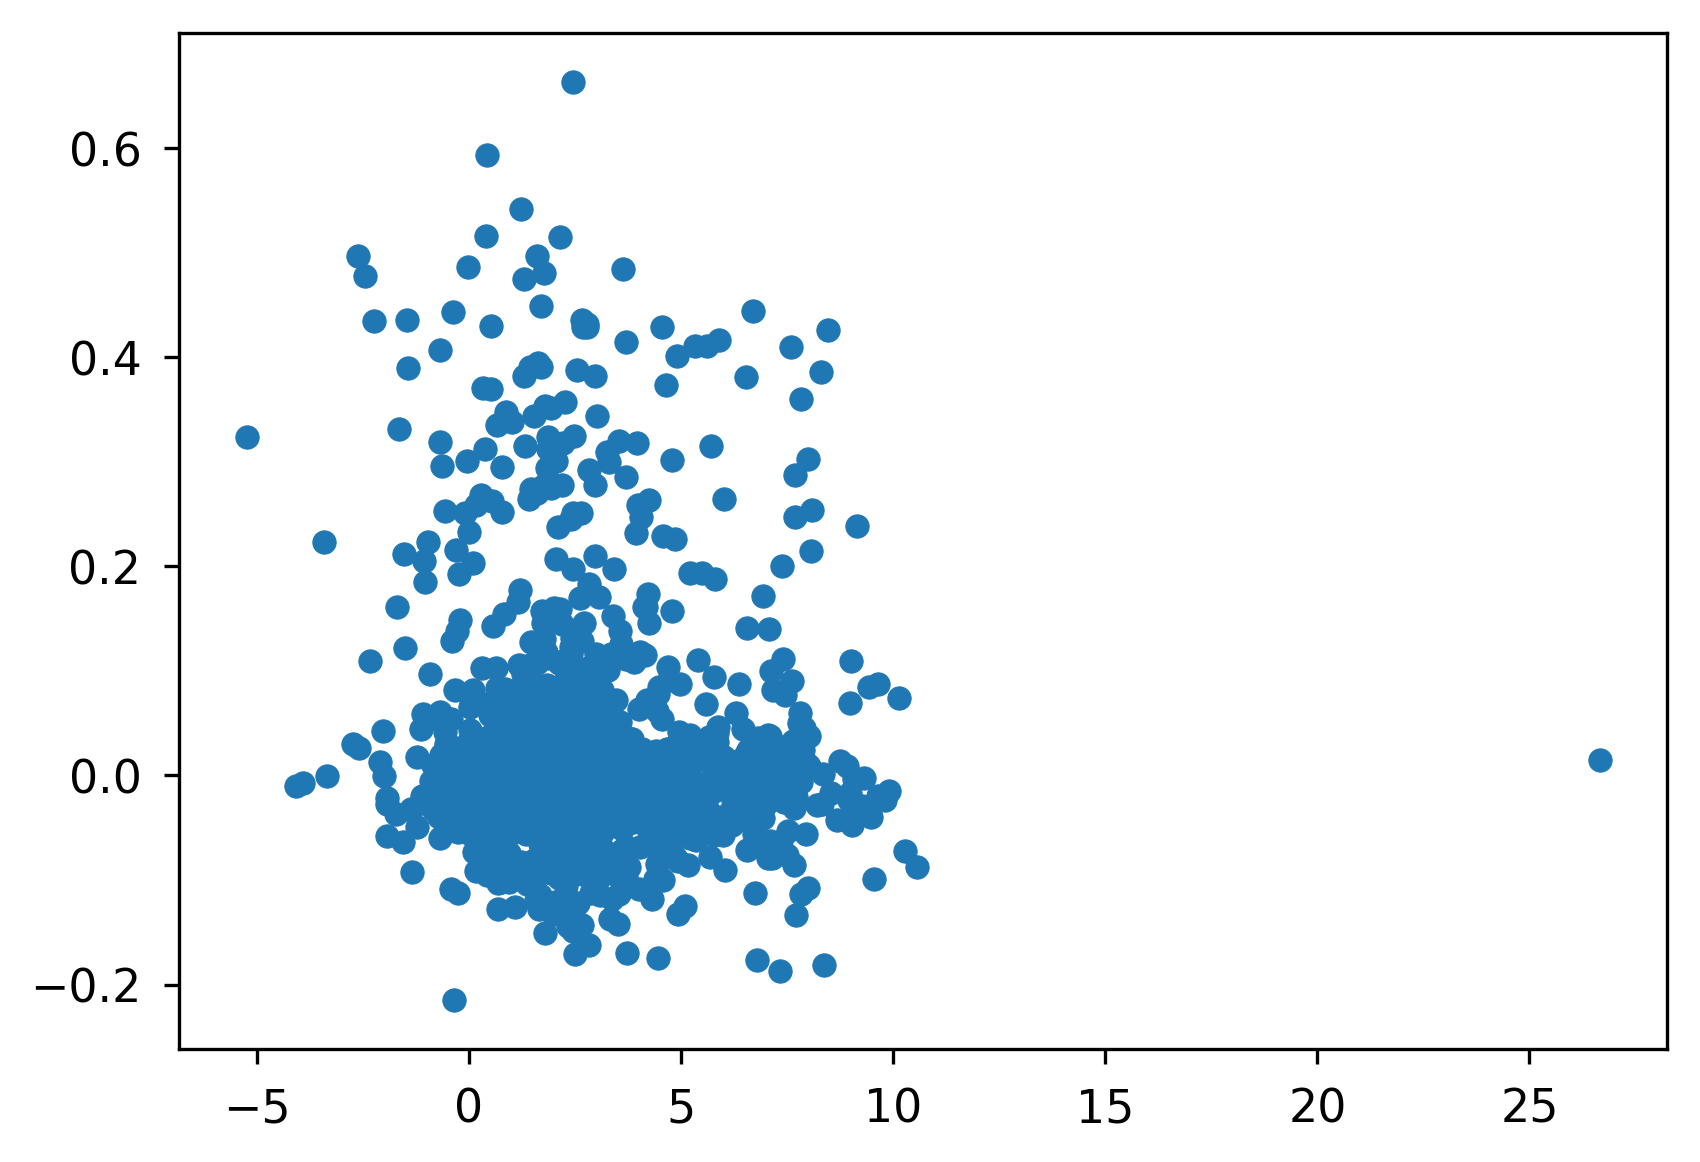

In [215]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    measured_delta,
    observed_delta,
)
fig.show()

In [216]:
scipy.stats.pearsonr(measured_delta, observed_delta)

(-0.09171736454202206, 0.0021721973709741696)